In [2]:
from google.colab import drive
drive.mount('/content/drive/')
path = ('/content/drive/MyDrive/courses/machine_learning/A4')

Mounted at /content/drive/


1. Install skorch for NeuralNetClassifier for the convenience of hyperparameter tuning.

In [3]:
pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 5.3 MB/s eta 0:00:00


2. Import Vital packages.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import skew, kurtosis
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

3. Define path for different motions and define window and step size.

In [34]:
# Define the name list of motions and sensors.
# There are 3 motions and each motion has dataset from 3 sensors.
motions = [path + '/JJx10-2023-11-19_19-24-30',
           path + '/Lux10-2023-11-19_19-33-46',
           path + '/Sqx10-2023-11-19_19-26-29']
sensors = ['/Accelerometer', '/Orientation', '/TotalAcceleration']

cols_selected = ['x_Acc', 'y_Acc', 'z_Acc','roll', 'pitch', 'yaw',
                   'x_Total', 'y_Total', 'z_Total','motion']

# Global variable dataframe_loaded
dataframe_loaded = pd.DataFrame()

# Define the size of window and stepsize.
# The step size is smaller than window size indicating that windows have overlaps
window_size = 5
step_size = 3

4. Import motion information from sensor files and do the preprocessing.

In [32]:
'''
load files for a referred motion and return a dataframe.
'time' and 'seconds_elapsed' are removed after data is loaded.
They are dropped because:
It doesn't involve any predictive information.
'''
def loadFileForMotion(motion) :
    filenames = [f"{motion}{sensor}.csv" for sensor in sensors]
    #print(filenames)
    dataframes_read = [pd.read_csv(filename).drop(["seconds_elapsed", "time"], axis=1) for filename in filenames]
    #dataframes_read[2].head(5)
    dataframe = dataframes_read[0].join(dataframes_read[1],lsuffix='_Acc', rsuffix='_Total')
    dataframe = dataframe.join(dataframes_read[2],lsuffix='_Acc', rsuffix='_Total')
    dataframe['motion'] = motion
    return dataframe
'''
 The returned framedata combines all features from all sensors for each motion
 with the axis=1 and then appends all motions in the list.
'''
def load_data_from_files() :
    dataframe_loaded = pd.concat(
        [loadFileForMotion(motions[0]),
         loadFileForMotion(motions[1]),
         loadFileForMotion(motions[2])])
    dataframe_loaded = dataframe_loaded[cols_selected]
    return dataframe_loaded
'''
 Data preprocess.  This function drop duplicates, fulfill NaN with mean values.
'''
def data_preprocess(dataframe_loaded):
    print("==========ENTER  data_process <<<<<<<<<<<")
    if not dataframe_loaded.empty:
        # For df in dataframe_loaded.items():
        # original_nan_count = dataframe_loaded.isna().sum().sum()
        dataframe_loaded.drop_duplicates(inplace=True)
        dataframe_loaded.replace([np.inf, -np.inf], np.nan, inplace=True)
        dataframe_loaded.ffill(inplace=True)

        # split 'motion' column before fullfill NaN with mean values,
        # since 'motion' column is not numerical.
        y = dataframe_loaded['motion']
        X = dataframe_loaded.drop('motion', axis=1)

        # Create an Inputer and fulfuill NaN with mean values.
        # Apply this imputer to all columns.
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

        # Before combining X and y it's suggested to reset index, otherwise
        # they will have common index.
        X.reset_index(drop=True, inplace=True)
        y.reset_index(drop=True, inplace=True)
        print(">>>>>>>>>>>LEAVE  data_process ==============")
        return pd.concat([X, y], axis=1)
    else:
        print(">>>>>>>>>>>LEAVE  data_process ==============")
        return dataframe_loaded


def add_noise(dataframe_loaded) :
    noise_level = 0.1
    for col in dataframe_loaded.columns:
        if col != 'motion':
            dataframe_loaded[col] = dataframe_loaded[col] + np.random.normal(0, noise_level, size=dataframe_loaded[col].shape)
    return dataframe_loaded

def mean_filter(dataframe_loaded):
    print("==========ENTER  mean_filter <<<<<<<<<<<")
    # Mean filtering
    for col in cols_selected:
        dataframe_loaded[col] = dataframe_loaded[col].rolling(window=window_size, min_periods=1).mean()
    print(">>>>>>>>>>>LEAVE  mean_filter ==============")
    return dataframe_loaded

# We choose to extract features 'x_Acc', 'y_Acc', 'z_Acc','roll', 'pitch', 'yaw',
# 'x_Total', 'y_Total', 'z_Total', where x_Acc is from the x value for accelerometer,
# and x_Total is from the total accelerate. We change the name to discriminate them.
# euler angles('roll', 'pitch', 'yaw') contain the same information with quaternion values so
# we only choose the euler angles because they are more intuitive and easier to
# understand.
def feature_extraction(dataframe_loaded):
    print("==========ENTER  feature_extraction <<<<<<<<<<<")
    features = []
    cols = ['x_Acc', 'y_Acc', 'z_Acc','roll', 'pitch', 'yaw',
            'x_Total', 'y_Total', 'z_Total']
    for start in range(0, dataframe_loaded.shape[0] - window_size + 1, step_size):
        end = start + window_size
        window_df = dataframe_loaded.iloc[start:end]
        line = [value
                for col in cols
                for value in [window_df[col].mean(),
                          window_df[col].std(),
                          skew(window_df[col], nan_policy='omit'),
                          kurtosis(window_df[col], nan_policy='omit'),
                          window_df[col].max(),
                          window_df[col].min()]
        ]
        line.append(round(window_df['motion'].iloc[0]))
        features.append(line)
    print(">>>>>>>>>>>LEAVE  feature_extraction ==============")
    return features

def feature_scaling(feature_df) :
    print("==========ENTER  feature_scaling <<<<<<<<<<<")
    # Fulfill NaN values with mean values.
    imputer = SimpleImputer(strategy='mean')

    # Split motion and other columns so we can scale the data parts.
    y = dataframe_loaded['motion']
    X = dataframe_loaded.drop('motion', axis=1)

    # Feature scaling
    X_imputed = imputer.fit_transform(X)
    scaler = StandardScaler()
    #scaler = MinMaxScaler()
    X_imputed_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

    # Use label encoder to transform motion column to numerical values.
    label_encoder = LabelEncoder()
    y = pd.DataFrame(label_encoder.fit_transform(y), columns = ['motion'])

    # Combine X and y before returnning it.
    X_imputed_scaled.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    feature_numeric_scaled = pd.concat([X_imputed_scaled, y], axis=1)
    print(">>>>>>>>>>>LEAVE  feature_scaling ==============")
    return feature_numeric_scaled

5. Define CNN, GRU, and hybrid classfier.

In [33]:
"""
Develop and train 1D CNN (Convolutional Neural Network) models appropriate for
sequential sensor data classification.
"""

class CNNClassifier(nn.Module):
    def __init__(self, conv_num=2, kernel_size=3):
        super(CNNClassifier, self).__init__()
        self.conv_num = conv_num
        if conv_num == 2:
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=kernel_size, padding=1)
            self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=kernel_size, padding=1)
            # pooling layer
            self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
            self.fc1 = nn.Linear(in_features=416, out_features=10)
            self.fc2 = nn.Linear(in_features=10, out_features=3)
        elif conv_num == 3:
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=kernel_size, padding=1)
            self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=kernel_size, padding=1)
            self.conv3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=kernel_size, padding=1)
            # pooling layer
            self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
            self.fc1 = nn.Linear(in_features=192, out_features=10)
            self.fc2 = nn.Linear(in_features=10, out_features=3)
        elif conv_num == 4:
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=kernel_size, padding=1)
            self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=kernel_size, padding=1)
            self.conv3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=kernel_size, padding=1)
            self.conv4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=kernel_size, padding=1)
            # pooling layer
            self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
            self.fc1 = nn.Linear(in_features=96, out_features=10)
            self.fc2 = nn.Linear(in_features=10, out_features=3)

    def forward(self, x):
        if self.conv_num == 2:
            # Apply convolution layer and ReLU activation function
            x = torch.relu(self.conv1(x))
            # pooling layer
            x = self.pool(x)
            x = torch.relu(self.conv2(x))
            x = self.pool(x)
            # Flattening features to input into the fully connected layer
            x = x.view(x.size(0), -1)
            x = torch.relu(self.fc1(x))
            # Application output layer
            x = self.fc2(x)
        elif self.conv_num == 3:
            # Apply convolution layer and ReLU activation function
            x = torch.relu(self.conv1(x))
            # pooling layer
            x = self.pool(x)
            x = torch.relu(self.conv2(x))
            x = self.pool(x)
            x = torch.relu(self.conv3(x))
            x = self.pool(x)
            # Flattening features to input into the fully connected layer
            x = x.view(x.size(0), -1)
            x = torch.relu(self.fc1(x))
            # Application output layer
            x = self.fc2(x)
        elif self.conv_num == 4:
            # Apply convolution layer and ReLU activation function
            x = torch.relu(self.conv1(x))
            # pooling layer
            x = self.pool(x)
            x = torch.relu(self.conv2(x))
            x = self.pool(x)
            x = torch.relu(self.conv3(x))
            x = self.pool(x)
            x = torch.relu(self.conv4(x))
            x = self.pool(x)
            # Flattening features to input into the fully connected layer
            x = x.view(x.size(0), -1)
            x = torch.relu(self.fc1(x))
            # Application output layer
            x = self.fc2(x)
        return x

"""
Define GRU (Gated Recurrent Unit) networks for sequential sensor
data classification.
"""
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_rate=0.0):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        last_output = self.dropout(gru_out[:, -1, :])
        output = self.fc(last_output)
        output_probs = self.softmax(output)
        return output_probs

"""
Define Hybrid model of GRU and CNN networks for sequential sensor
data classification.
"""
class HybridModel(nn.Module):
    def __init__(self, input_size, output_size, conv_channels, gru_hidden_size, num_gru_layers):
        super(HybridModel, self).__init__()

        # Input Layer
        self.input_layer = nn.Identity()

        # Convolutional Layers. We use a sqeuencital to encapsule
        # multiple layers for the convolution to simplify the definition.
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=conv_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        # GRU layer
        self.gru = nn.GRU(input_size=conv_channels, hidden_size=gru_hidden_size, num_layers=num_gru_layers, batch_first=True)
        # Output Layer, like the GRU model, it keeps the linear layer and softmax.
        self.fc = nn.Linear(gru_hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Input Layer
        x = self.input_layer(x)

        # Convolutional Layers
        x = self.conv_layers(x)

        # Flattening or Global Pooling
        #x = self.global_pooling(x)

        # Reshape for GRU
        x = x.squeeze(dim=-1).unsqueeze(1)

        # Recurrent Layers (GRU)
        gru_out, _ = self.gru(x)

        # Output Layer
        last_output = gru_out[:, -1, :]
        output = self.fc(last_output)
        output_probs = self.softmax(output)
        return output_probs

6. Define model training function.

In [15]:
def train_model(model, input_seq, target_seq, criterion, optimizer, epochs=500) :
  #input_seq = input_seq.unsqueeze(1)
  loss_list = []
  print(f"input_seq shape = {input_seq.shape}")
  for epoch in range(epochs):
      # Reset the gradient to zero in case of accumulation.
      optimizer.zero_grad()
      # Forward propogation
      output = model(input_seq)
      # Calculate the loss using criterion.
      loss = criterion(output, target_seq)
      # Calculate the backpropogation
      loss.backward()
      # Update the weightes based on the gradients.
      optimizer.step()
      # Print the debugging information for loss function
      loss_list.append(loss.item())
      if epoch % 50 == 0:
          print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
  return loss_list

def train_model_with_batch_size(model, input_seq, target_seq, criterion, optimizer, batch_size=100, epochs=500) :
    input_seq = input_seq.unsqueeze(1)
    model.train()
    loss_result = []
    for epoch in range(epochs):
        total_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            # Get batch data
            inputs = input_seq[i:i + batch_size]
            labels = target_seq[i:i + batch_size]

            # Clear the old gradient
            optimizer.zero_grad()

            # Forward propagation
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            total_loss = total_loss + loss.item()

        loss_result.append(total_loss)
        print(f'Epoch {epoch + 1}, Loss: {total_loss:.4f}')
    return loss_result


# Predicting
def predict(model, inputs):
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted_labels = torch.max(outputs, 1)
    return predicted_labels

# Predicting
def cnn_predict(model, inputs):
    predicts = []
    inputs = inputs.unsqueeze(1)
    with torch.no_grad():
        for i in range(0, len(inputs)):
            outputs = model(inputs[i])
            _, predicted_label = torch.max(outputs, 1)
            predicts.append(predicted_label.item())
    return torch.tensor(predicts, dtype=torch.long)

7. Define classifier evaluation function,

In [16]:
def plot_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()
  return cm

def evaluate_classifer(y_test, y_predictions, algorithm, if_print_detailed_report=False) :
    # Calculate the accuracy.
    accuracy = accuracy_score(y_test, y_predictions)
    # Calculate the precision, recall rate and f1 score.
    precision = precision_score(y_test, y_predictions, average='weighted')
    recall_rate = recall_score(y_test, y_predictions, average='weighted')
    f1_score_value = f1_score(y_test, y_predictions, average='weighted')

    if if_print_detailed_report :
        # Generate the confusion matrix.
        confusion_matrix = plot_confusion_matrix(y_test, y_predictions)
        # Print the report if necessary.
        print(f"{algorithm} Accuracy:", accuracy)
        print(f"{algorithm} Confusion Matrix:\n{confusion_matrix}")
        print(f"{algorithm} Precision: {precision}")
        print(f"{algorithm} Recall: {recall_rate}")
        print(f"{algorithm} F1 Score: {f1_score_value}")
        # Print the classifer analysis if necessary.
        print(f"{algorithm} Classifier Report:")
        print(classification_report(y_test, y_predictions))
    return accuracy, precision, recall_rate, f1_score_value

8. Define hyperparameter tuning function using GridSearchCV, this is used for hyperparameter tuning for GRU.

In [17]:
def hyperparam_tuning(Classifier, param_grid, X_train, y_train, scoring='f1_weighted'):

  # Create a classifier model which can be accepted by sklearner.
  gru_model = NeuralNetClassifier(
      Classifier,
      # Use CrossEntropyLoss as the loss func
      criterion=nn.CrossEntropyLoss,
      optimizer=optim.Adam,
      max_epochs=300,
      batch_size=1200,
      # The last element is the input size.
      module__input_size=X_train.shape[2],
      module__output_size=3
  )

  # Cross validation for time series data with 5 folds.
  tscv = TimeSeriesSplit(n_splits=5)

  # Use GridSearchCV to search the optimal hyperparameter
  grid = GridSearchCV(estimator=gru_model, param_grid=param_grid, cv=tscv, scoring=scoring, verbose=1)
  grid_result = grid.fit(X_train, y_train)

  # Print the beat parameter
  print("Best Parameters: ", grid_result.best_params_)
  return grid_result.best_params_

9. Main function entry.

9.1 Run data preprocessing.

In [18]:
if __name__ == '__main__':
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataframe_loaded = load_data_from_files()
    print(dataframe_loaded)
    dataframe_loaded = data_preprocess(dataframe_loaded)
    dataframe_scaled = feature_scaling(dataframe_loaded)
    dataframe_meaned = mean_filter(dataframe_scaled)
    dataframe_noised = add_noise(dataframe_meaned)

    # Use previous solution to extract the numerical characteristics.
    features_list = feature_extraction(dataframe_noised)
    # Convert the list to data frame to save in a csv file.
    feature_df = pd.DataFrame(features_list)
    feature_df.to_csv('feature_df.csv', sep=',', index=False, encoding='utf-8')
    #feature_df = scaler.fit_transform(feature_df)
    # Split X from y to do data spliting.
    X = feature_df.iloc[:, :-1]
    y = feature_df.iloc[:, -1]

    X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X, y, test_size=0.2, random_state=42)

         x_Acc     y_Acc     z_Acc      roll     pitch       yaw   x_Total  \
0     0.000000  0.000000  0.000000 -0.017613 -0.242240 -1.213133  0.687338   
1    -0.182402  0.092417  0.108608 -0.017613 -0.242240 -1.213133  0.203689   
2    -0.302392  0.324736 -0.317981 -0.017613 -0.242240 -1.213133 -0.186640   
3    -0.444053  0.224480 -1.008744 -0.017613 -0.242240 -1.213133 -0.565005   
4    -0.398248  0.275390 -0.935632 -0.017613 -0.242240 -1.213133 -0.677468   
...        ...       ...       ...       ...       ...       ...       ...   
2152 -0.810892 -1.011379  4.145944 -1.351173  0.029661 -2.720479  1.245165   
2153  1.141571  0.622580  1.649941 -1.334966  0.030671 -2.718737  3.083750   
2154  0.065402  0.304213 -0.168256 -1.333355  0.030772 -2.718565  1.848456   
2155 -0.316782  0.575909 -2.171528 -1.313223  0.030860 -2.718625  1.343271   
2156 -1.152588  0.080147 -2.301008 -1.313223  0.030860 -2.718625  0.490828   

       y_Total    z_Total                                      

In [19]:
feature_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,-0.054426,0.137061,-0.021385,-1.316542,0.111713,-0.232339,0.235246,0.151928,0.408002,-0.641905,...,-0.155472,2.468064,1.963047,2.557746,0.144028,-1.268194,-0.104415,2.657455,2.309042,0
1,0.030960,0.167095,-0.703561,-0.637297,0.208666,-0.232339,0.391599,0.121424,0.054380,-1.522691,...,-1.252230,2.829583,2.347435,2.328968,0.185910,0.930165,-0.493844,2.633175,2.176941,0
2,0.003874,0.081920,0.421267,-0.572803,0.128238,-0.098529,0.284257,0.185665,0.510602,-1.388536,...,-1.491724,2.871816,2.535910,2.276285,0.133278,0.445448,-1.174648,2.468293,2.138156,0
3,0.024032,0.078243,-0.680650,-0.699609,0.104506,-0.098529,0.051115,0.103380,0.550003,-1.227335,...,-0.207393,2.783507,2.545671,2.216214,0.152763,1.029490,-0.503510,2.468293,2.095614,0
4,0.060414,0.153109,-0.059833,-0.670510,0.270062,-0.155143,-0.163285,0.134080,-0.363343,-1.196229,...,-0.506408,2.619722,2.318272,2.167775,0.063270,0.392799,-1.007417,2.259873,2.095614,0
5,0.068029,0.116470,1.287776,-0.048478,0.270062,-0.012509,-0.164578,0.091926,0.724545,-0.607737,...,-0.856308,2.663148,2.336399,2.340892,0.149876,-0.392269,-1.784030,2.464406,2.162639,0
6,0.014936,0.095428,0.129179,-0.618640,0.152005,-0.114233,-0.182310,0.138328,-0.208529,-1.143819,...,-1.263564,2.663148,2.336399,2.394966,0.091297,-1.021744,-0.484515,2.464406,2.244205,0
7,0.001960,0.097997,-0.153876,-1.627189,0.110888,-0.114233,-0.228540,0.106962,-0.313700,-1.419127,...,-1.572754,2.710145,2.423832,2.423286,0.152584,-0.571774,-0.922633,2.574987,2.191978,0
8,0.004599,0.068550,-0.067188,-1.467352,0.074486,-0.083858,-0.030834,0.154707,0.195498,-1.491838,...,-0.829774,3.005837,2.505491,2.240551,0.185421,0.936390,-0.534304,2.543119,2.080176,0
9,-0.010519,0.074993,-0.230947,-1.194020,0.072874,-0.115131,0.115663,0.092554,-1.295886,-0.045018,...,-0.744764,3.005837,2.856572,2.142780,0.087153,0.867767,-0.718266,2.282021,2.069739,0


9.2 Train and run CNN models and evluate the performance.

---------------------------
torch.Size([1808, 54])
input_seq shape = torch.Size([1808, 1, 54])
Epoch [1/500], Loss: 1.0951
Epoch [51/500], Loss: 1.0612
Epoch [101/500], Loss: 1.0240
Epoch [151/500], Loss: 0.9757
Epoch [201/500], Loss: 0.9177
Epoch [251/500], Loss: 0.8473
Epoch [301/500], Loss: 0.7674
Epoch [351/500], Loss: 0.6826
Epoch [401/500], Loss: 0.5998
Epoch [451/500], Loss: 0.5260


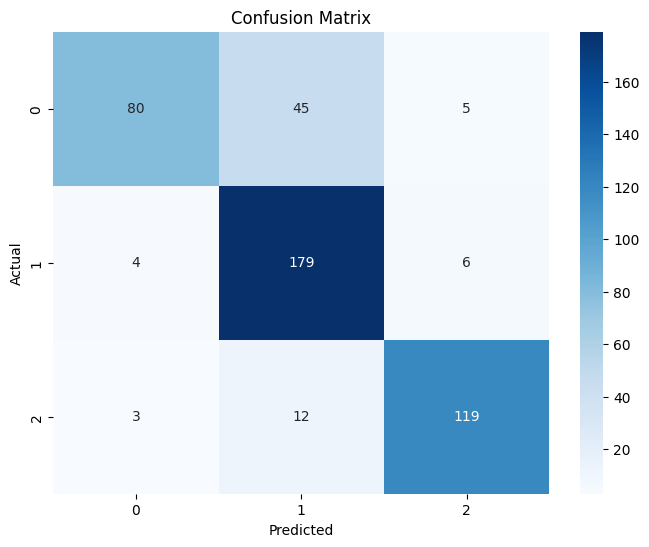

CNN Accuracy: 0.8344370860927153
CNN Confusion Matrix:
[[ 80  45   5]
 [  4 179   6]
 [  3  12 119]]
CNN Precision: 0.851111397929029
CNN Recall: 0.8344370860927153
CNN F1 Score: 0.8297136219593714
CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.92      0.62      0.74       130
           1       0.76      0.95      0.84       189
           2       0.92      0.89      0.90       134

    accuracy                           0.83       453
   macro avg       0.86      0.82      0.83       453
weighted avg       0.85      0.83      0.83       453



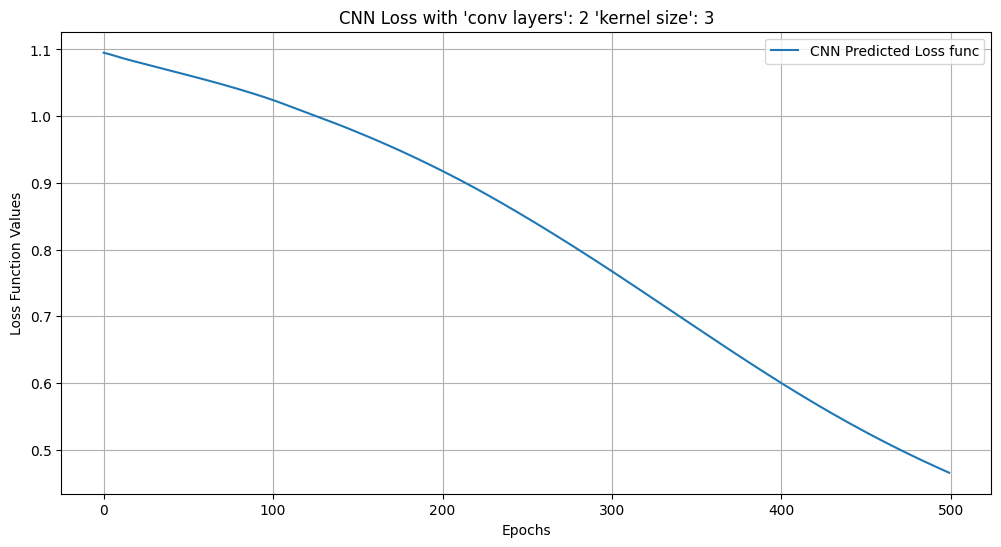

input_seq shape = torch.Size([1808, 1, 54])
Epoch [1/500], Loss: 1.0729
Epoch [51/500], Loss: 1.0615
Epoch [101/500], Loss: 1.0494
Epoch [151/500], Loss: 1.0343
Epoch [201/500], Loss: 1.0154
Epoch [251/500], Loss: 0.9899
Epoch [301/500], Loss: 0.9538
Epoch [351/500], Loss: 0.9019
Epoch [401/500], Loss: 0.8294
Epoch [451/500], Loss: 0.7353


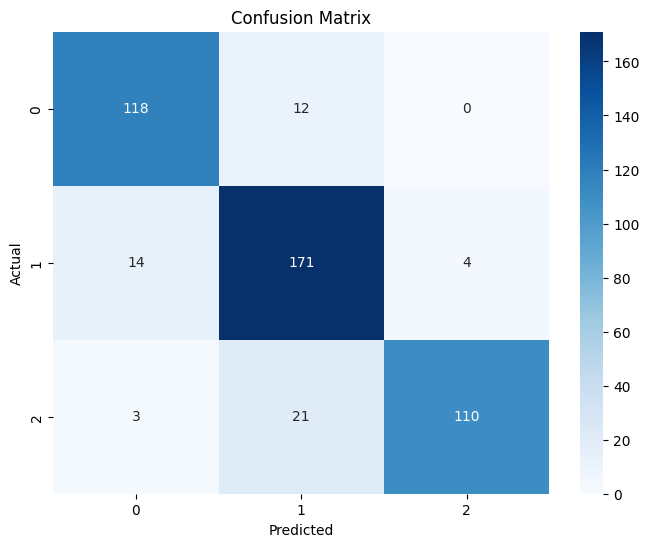

CNN Accuracy: 0.8807947019867549
CNN Confusion Matrix:
[[118  12   0]
 [ 14 171   4]
 [  3  21 110]]
CNN Precision: 0.8859919334037527
CNN Recall: 0.8807947019867549
CNN F1 Score: 0.8810548235989933
CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       130
           1       0.84      0.90      0.87       189
           2       0.96      0.82      0.89       134

    accuracy                           0.88       453
   macro avg       0.89      0.88      0.88       453
weighted avg       0.89      0.88      0.88       453



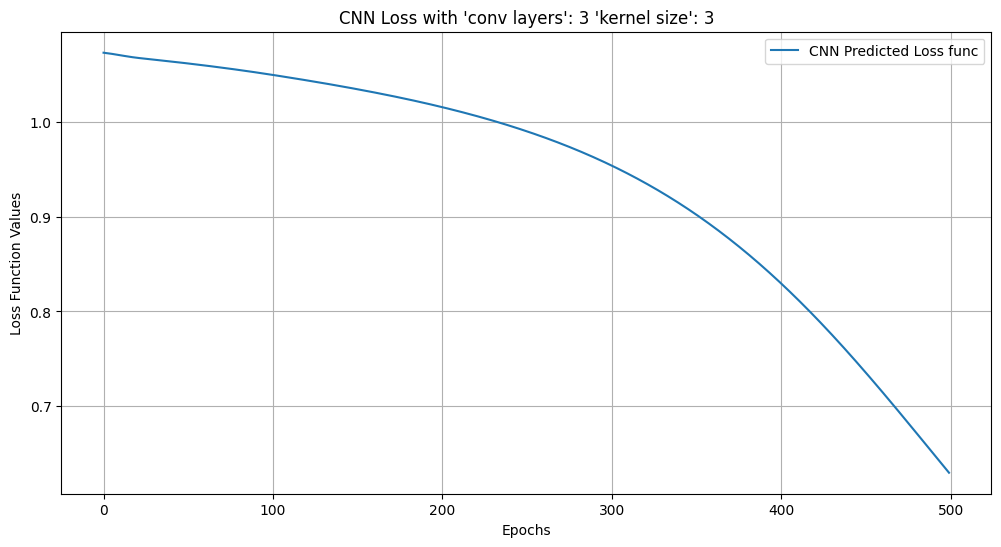

input_seq shape = torch.Size([1808, 1, 54])
Epoch [1/500], Loss: 1.0832
Epoch [51/500], Loss: 1.0466
Epoch [101/500], Loss: 1.0110
Epoch [151/500], Loss: 0.9674
Epoch [201/500], Loss: 0.9115
Epoch [251/500], Loss: 0.8408
Epoch [301/500], Loss: 0.7568
Epoch [351/500], Loss: 0.6651
Epoch [401/500], Loss: 0.5733
Epoch [451/500], Loss: 0.4893


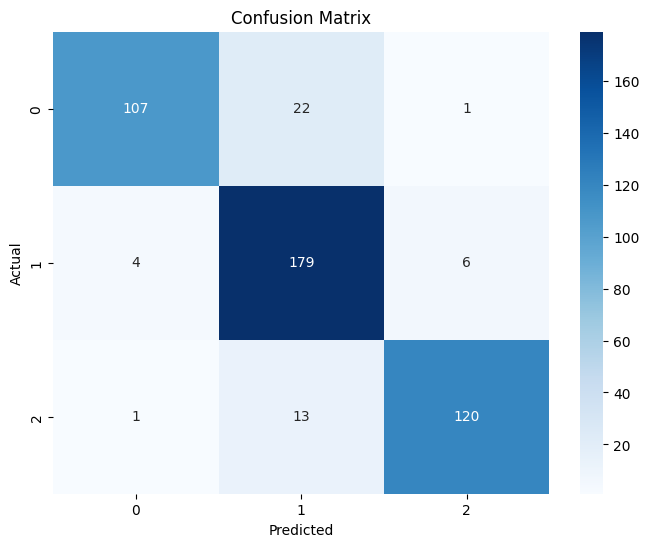

CNN Accuracy: 0.8962472406181016
CNN Confusion Matrix:
[[107  22   1]
 [  4 179   6]
 [  1  13 120]]
CNN Precision: 0.9026476530827904
CNN Recall: 0.8962472406181016
CNN F1 Score: 0.8964080576782898
CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.88       130
           1       0.84      0.95      0.89       189
           2       0.94      0.90      0.92       134

    accuracy                           0.90       453
   macro avg       0.91      0.89      0.90       453
weighted avg       0.90      0.90      0.90       453



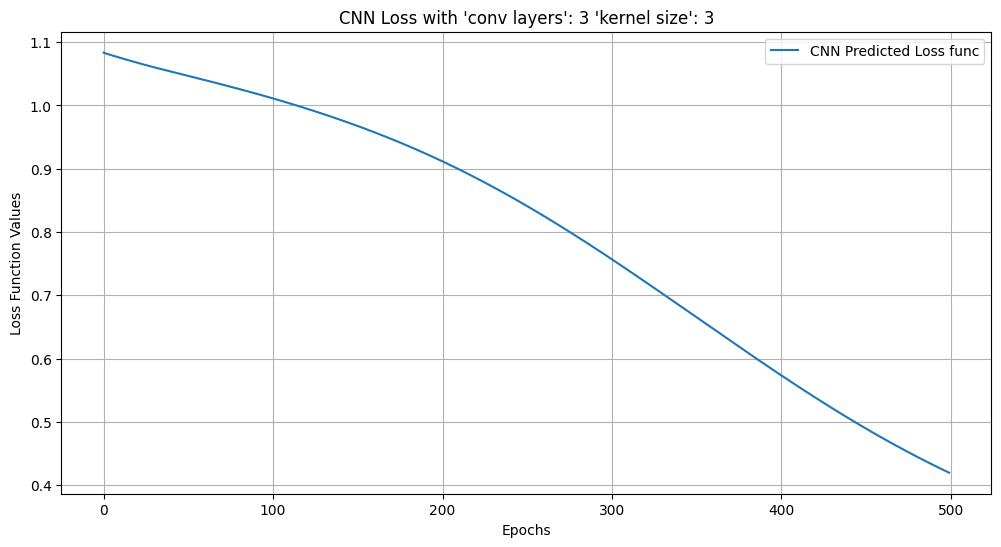

In [20]:
    # Convert data to tensor type.
    X_train = torch.tensor(X_train_data.to_numpy(), dtype=torch.float32)
    X_test = torch.tensor(X_test_data.to_numpy(), dtype=torch.float32)
    y_train = torch.tensor(y_train_data.to_numpy(), dtype=torch.long)
    y_test = torch.tensor(y_test_data.to_numpy(), dtype=torch.long)

    output_size = 3
    #hidden_size = 64
    input_size = 54
    learning_rate = 0.01
    print("---------------------------")
    print(X_train.shape)

#-----------CNN-------------------
    conv_layer_num = 2
    kernel_size =3
    cnn_model = CNNClassifier(conv_num=conv_layer_num, kernel_size=kernel_size)
    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=0.01)
    cnn_criterion = nn.CrossEntropyLoss()
    batch_size=100
    epochs=500
    #loss_result = train_model_with_batch_size(cnn_model, X_train, y_train, cnn_criterion, cnn_optimizer, batch_size, epochs)
    loss_result = train_model(cnn_model, X_train.unsqueeze(1), y_train, cnn_criterion, cnn_optimizer, epochs)

    cnn_predicts = cnn_predict(cnn_model,X_test.unsqueeze(1))
    evaluate_classifer(y_test, cnn_predicts, "CNN", if_print_detailed_report=True)

    plt.figure(figsize=(12, 6))
    plt.plot(range(0, epochs, 1), loss_result, label="CNN Predicted Loss func")
    plt.legend()
    plt.title(f"CNN Loss with 'conv layers': {2} 'kernel size': {3}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Function Values")
    plt.grid(True)
    plt.show()

    conv_layer_num = 2
    kernel_size =3
    cnn_model = CNNClassifier(conv_num=conv_layer_num, kernel_size=kernel_size)
    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=0.01)
    cnn_criterion = nn.CrossEntropyLoss()
    #loss_result = train_model_with_batch_size(cnn_model, X_train, y_train, cnn_criterion, cnn_optimizer, batch_size, epochs)
    loss_result = train_model(cnn_model, X_train.unsqueeze(1), y_train, cnn_criterion, cnn_optimizer, epochs)

    cnn_predicts = cnn_predict(cnn_model,X_test.unsqueeze(1))
    evaluate_classifer(y_test, cnn_predicts, "CNN", True)

    plt.figure(figsize=(12, 6))
    plt.plot(range(0, epochs, 1), loss_result, label="CNN Predicted Loss func")
    plt.legend()
    plt.title(f"CNN Loss with 'conv layers': {3} 'kernel size': {3}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Function Values")
    plt.grid(True)
    plt.show()

    conv_layer_num = 2
    kernel_size =3
    cnn_model = CNNClassifier(conv_num=conv_layer_num, kernel_size=kernel_size)
    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=0.01)
    cnn_criterion = nn.CrossEntropyLoss()
    #loss_result = train_model_with_batch_size(cnn_model, X_train, y_train, cnn_criterion, cnn_optimizer, batch_size, epochs)
    loss_result = train_model(cnn_model, X_train.unsqueeze(1), y_train, cnn_criterion, cnn_optimizer, epochs)

    cnn_predicts = cnn_predict(cnn_model,X_test.unsqueeze(1))
    evaluate_classifer(y_test, cnn_predicts, "CNN", True,)

    plt.figure(figsize=(12, 6))
    plt.plot(range(0, epochs, 1), loss_result, label="CNN Predicted Loss func")
    plt.legend()
    plt.title(f"CNN Loss with 'conv layers': {3} 'kernel size': {3}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Function Values")
    plt.grid(True)
    plt.show()


#--------------CNN-------------------------------------------------------------

9.3 Run hypperparameter tuning for GRU classfier.

In [21]:
    # Define the hyperparameter space.
    param_grid = {
        'module__dropout_rate': [0.2, 0.5],
        'module__num_layers': [2, 3],
        'module__hidden_size': [50, 100],
    }

    best_parameters = hyperparam_tuning(GRUClassifier, param_grid, X_train.unsqueeze(1), y_train, scoring='f1_weighted')
    print("best_parameters = ",best_parameters)

Streaming output truncated to the last 5000 lines.
    135        0.6022       0.9437        0.6046  0.0581
    136        0.6018       0.9404        0.6064  0.0624
    137        0.6027       0.9404        0.6046  0.0562
    138        0.6032       0.9470        0.6027  0.0549
    139        0.6038       0.9503        0.6011  0.0548
    140        0.6006       0.9570        0.5970  0.0520
    141        0.6025       0.9503        0.6021  0.0530
    142        0.6030       0.9437        0.6056  0.0594
    143        0.6032       0.9470        0.6038  0.0495
    144        0.6066       0.9503        0.5992  0.0495
    145        0.6032       0.9536        0.5973  0.0491
    146        0.6047       0.9503        0.6012  0.0507
    147        0.6029       0.9470        0.6078  0.0517
    148        0.6017       0.9437        0.6102  0.0591
    149        0.6031       0.9404        0.6117  0.0595
    150        0.6026       0.9404        0.6104  0.0528
    151        0.6023       0.9437   

9.4 Run the GRU classfier with the tuned best hyperparameters.
From the tuning, we get the best dropout rate and the best hidden size, layer number, so the final architecture is decided.

input_seq shape = torch.Size([1808, 1, 54])
Epoch [1/300], Loss: 1.0981
Epoch [51/300], Loss: 0.6101
Epoch [101/300], Loss: 0.5910
Epoch [151/300], Loss: 0.5652
Epoch [201/300], Loss: 0.5628
Epoch [251/300], Loss: 0.5619


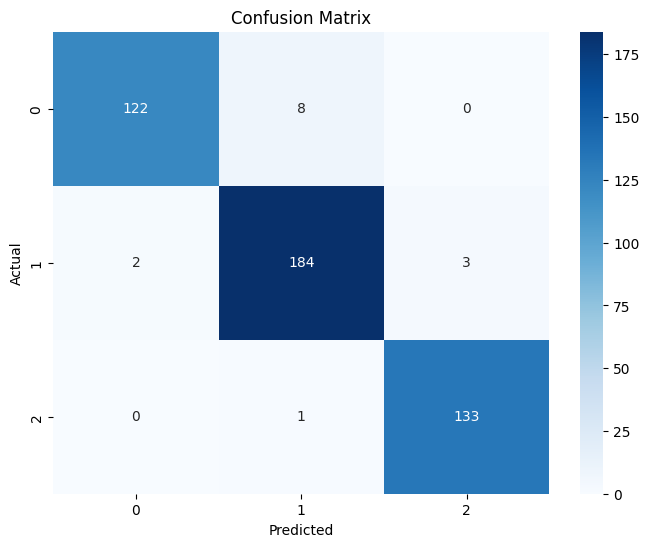

GRU Accuracy: 0.9690949227373068
GRU Confusion Matrix:
[[122   8   0]
 [  2 184   3]
 [  0   1 133]]
GRU Precision: 0.9693904458077697
GRU Recall: 0.9690949227373068
GRU F1 Score: 0.9690287042117302
GRU Classifier Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       130
           1       0.95      0.97      0.96       189
           2       0.98      0.99      0.99       134

    accuracy                           0.97       453
   macro avg       0.97      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453

[1.0981395244598389, 1.0569279193878174, 0.9972756505012512, 0.9231553673744202, 0.8402494788169861, 0.7857336401939392, 0.73710697889328, 0.7016511559486389, 0.6877420544624329, 0.6826422810554504, 0.6727992296218872, 0.6643416285514832, 0.6543096899986267, 0.6470667719841003, 0.6450515985488892, 0.6393600106239319, 0.639205276966095, 0.6339743733406067, 0.6322346925735474, 0.6264522075653076,

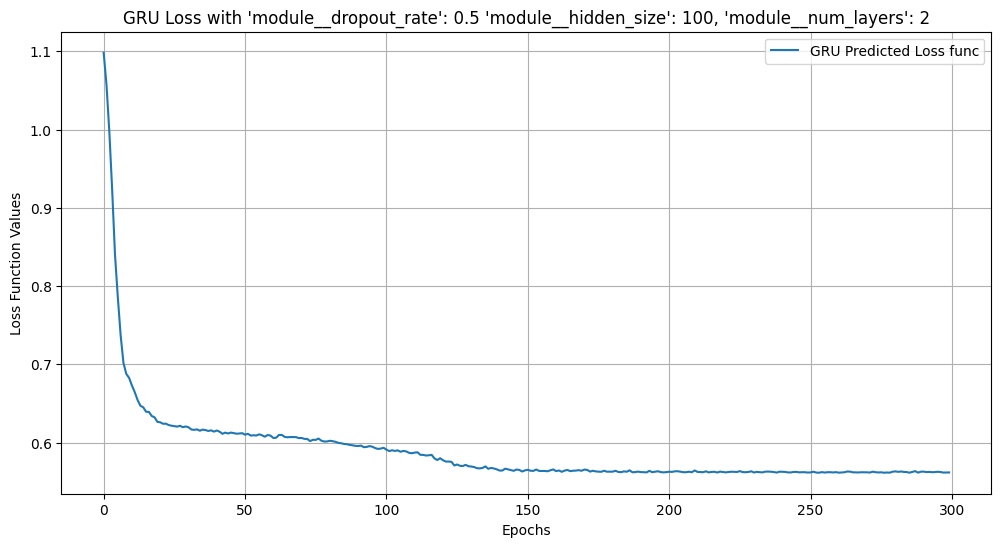

In [22]:
    dropout_rate = best_parameters['module__dropout_rate']
    hidden_size = best_parameters['module__hidden_size']
    num_layers = best_parameters['module__num_layers']
    gru_model = GRUClassifier(input_size, hidden_size, output_size, num_layers, dropout_rate)
    gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    epochs = 300
    batch_size = 500
    loss_list = train_model(gru_model, X_train.unsqueeze(1), y_train, criterion, gru_optimizer, epochs)

    # Test the GRU Model
    gru_test_outputs = predict(gru_model,X_test.unsqueeze(1))

    evaluate_classifer(y_test, gru_test_outputs, "GRU", if_print_detailed_report=True)
    print(loss_list)
    plt.figure(figsize=(12, 6))
    plt.plot(range(0, epochs, 1), loss_list, label="GRU Predicted Loss func")  # Add this line for GRU
    plt.legend()
    plt.title(f"GRU Loss with 'module__dropout_rate': {dropout_rate} 'module__hidden_size': {hidden_size}, 'module__num_layers': {num_layers}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Function Values")
    plt.grid(True)
    plt.show()

Although, we tried with some extra hidden_size to compare the performance. And the tuned hidden_size was proved to be convincing.

input_seq shape = torch.Size([1808, 1, 54])
Epoch [1/300], Loss: 1.1023
Epoch [51/300], Loss: 0.6149
Epoch [101/300], Loss: 0.5948
Epoch [151/300], Loss: 0.5790
Epoch [201/300], Loss: 0.5651
Epoch [251/300], Loss: 0.5633


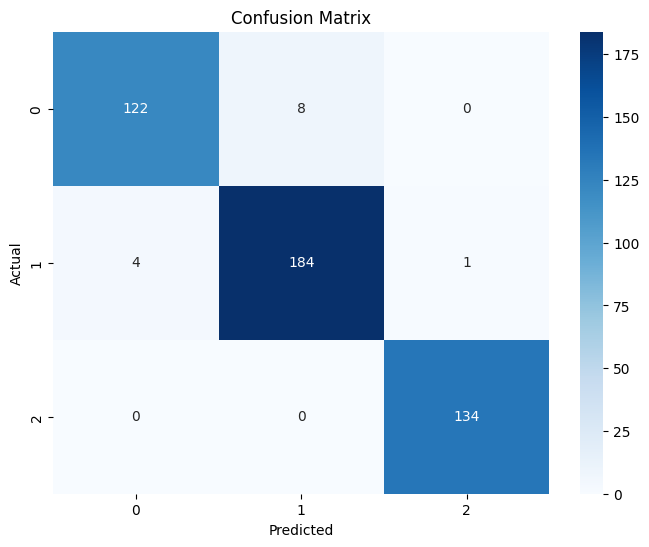

GRU Accuracy: 0.9713024282560706
GRU Confusion Matrix:
[[122   8   0]
 [  4 184   1]
 [  0   0 134]]
GRU Precision: 0.9713144001775349
GRU Recall: 0.9713024282560706
GRU F1 Score: 0.9712125603497167
GRU Classifier Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       130
           1       0.96      0.97      0.97       189
           2       0.99      1.00      1.00       134

    accuracy                           0.97       453
   macro avg       0.97      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453



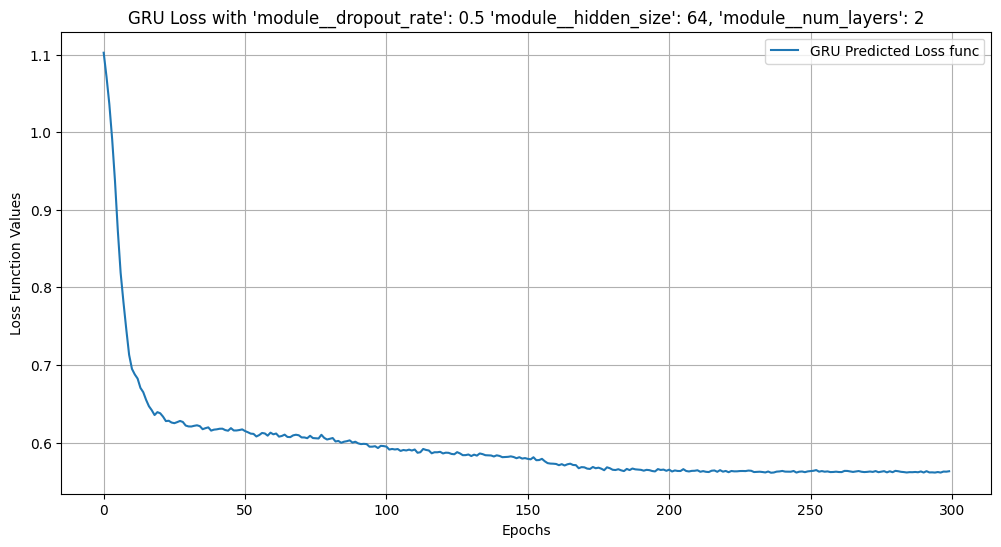

In [23]:
    # Keep dropout rate and change hidden_size to 64
    hidden_size = 64
    gru_model = GRUClassifier(input_size, hidden_size, output_size, num_layers, dropout_rate)
    gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    epochs = 300
    batch_size = 100
    #loss_list = train_model_with_batch_size(gru_model, X_train, y_train, criterion, gru_optimizer,  batch_size, epochs)
    loss_list = train_model(gru_model, X_train.unsqueeze(1), y_train, criterion, gru_optimizer, epochs)

    # Test the GRU Model
    gru_test_outputs = predict(gru_model, X_test.unsqueeze(1))

    evaluate_classifer(y_test, gru_test_outputs, "GRU", if_print_detailed_report=True)
    plt.figure(figsize=(12, 6))
    plt.plot(range(0, epochs, 1), loss_list, label="GRU Predicted Loss func")  # Add this line for GRU
    plt.legend()
    plt.title(f"GRU Loss with 'module__dropout_rate': {dropout_rate} 'module__hidden_size': {hidden_size}, 'module__num_layers': {num_layers}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Function Values")
    plt.grid(True)
    plt.show()

In [ ]:
    # Keep dropout rate and change hidden_size to 80
    hidden_size = 80
    gru_model = GRUClassifier(input_size, hidden_size, output_size, num_layers, dropout_rate)
    gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    loss_list = train_model(gru_model, X_train.unsqueeze(1), y_train, criterion, gru_optimizer, epochs)
    # Test the GRU Model
    gru_test_outputs = predict(gru_model, X_test.unsqueeze(1))

    evaluate_classifer(y_test, gru_test_outputs, True, "GRU")
    plt.figure(figsize=(12, 6))
    plt.plot(range(0, epochs, 1), loss_list, label="GRU Predicted Loss func")  # Add this line for GRU
    plt.legend()
    plt.title(f"GRU Loss with 'module__dropout_rate': {dropout_rate} 'module__hidden_size': {hidden_size}, 'module__num_layers': {num_layers}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Function Values")
    plt.grid(True)
    plt.show()

input_seq shape = torch.Size([1808, 1, 54])
Epoch [1/300], Loss: 1.0979
Epoch [51/300], Loss: 0.6104
Epoch [101/300], Loss: 0.5936
Epoch [151/300], Loss: 0.5638
Epoch [201/300], Loss: 0.5625
Epoch [251/300], Loss: 0.5619


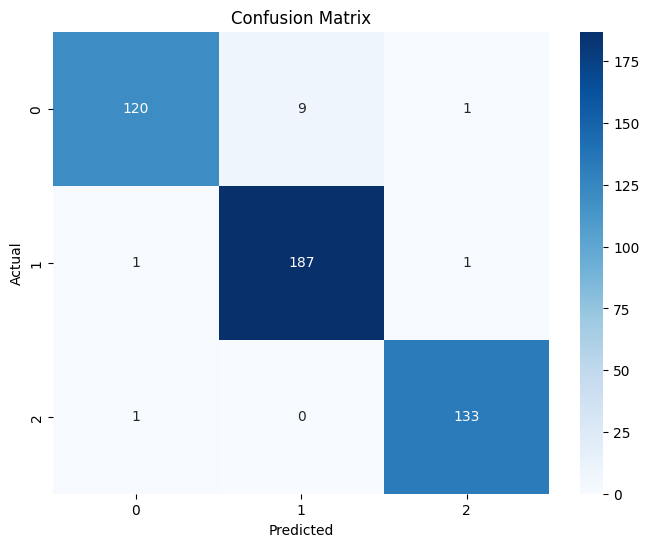

GRU Accuracy: 0.9713024282560706
GRU Confusion Matrix:
[[120   9   1]
 [  1 187   1]
 [  1   0 133]]
GRU Precision: 0.9717551784663571
GRU Recall: 0.9713024282560706
GRU F1 Score: 0.9711150110766054
GRU Classifier Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       130
           1       0.95      0.99      0.97       189
           2       0.99      0.99      0.99       134

    accuracy                           0.97       453
   macro avg       0.97      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453



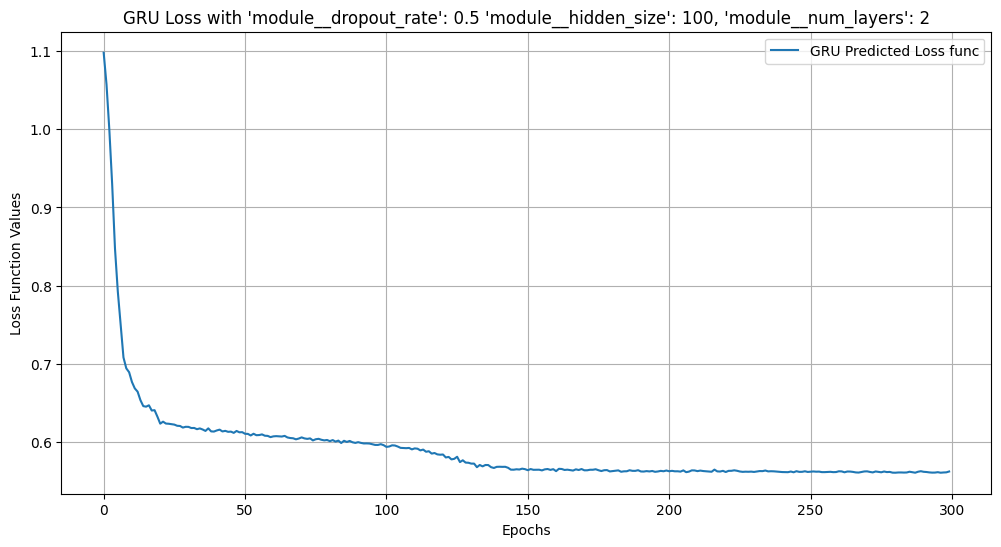

In [25]:
    # Keep dropout rate and change hidden_size to 100
    hidden_size = 100
    gru_model = GRUClassifier(input_size, hidden_size, output_size, num_layers, dropout_rate)
    gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    loss_list = train_model(gru_model, X_train.unsqueeze(1), y_train, criterion, gru_optimizer, epochs)
    # Test the GRU Model
    gru_test_outputs = predict(gru_model, X_test.unsqueeze(1))

    evaluate_classifer(y_test, gru_test_outputs, "GRU", True)
    plt.figure(figsize=(12, 6))
    plt.plot(range(0, epochs, 1), loss_list, label="GRU Predicted Loss func")  # Add this line for GRU
    plt.legend()
    plt.title(f"GRU Loss with 'module__dropout_rate': {dropout_rate} 'module__hidden_size': {hidden_size}, 'module__num_layers': {num_layers}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Function Values")
    plt.grid(True)
    plt.show()

9.5. The hybrid classifier used the hyperparameters which were tuned by GRU. But the dropout rate was not used.
The convolution size should then be tuned. We then iterate convolution size from 30 to 150 and compare the performance for each value. And found out the relatively best value.

------------------------- for conv_channels = 30-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.1001
Epoch [51/500], Loss: 0.6103
Epoch [101/500], Loss: 0.5979
Epoch [151/500], Loss: 0.5929
Epoch [201/500], Loss: 0.5929
Epoch [251/500], Loss: 0.5929
Epoch [301/500], Loss: 0.5928
Epoch [351/500], Loss: 0.5928
Epoch [401/500], Loss: 0.5928
Epoch [451/500], Loss: 0.5928


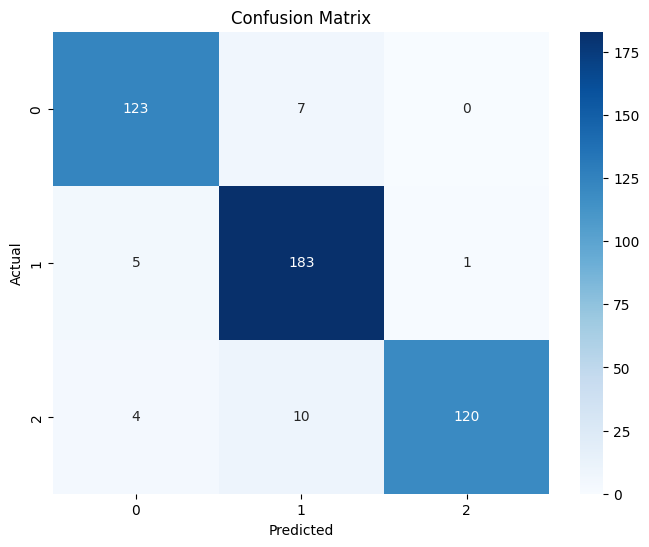

Hybrid of GRU and CNN Accuracy: 0.9403973509933775
Hybrid of GRU and CNN Confusion Matrix:
[[123   7   0]
 [  5 183   1]
 [  4  10 120]]
Hybrid of GRU and CNN Precision: 0.9425252221188404
Hybrid of GRU and CNN Recall: 0.9403973509933775
Hybrid of GRU and CNN F1 Score: 0.9404059791681458
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       130
           1       0.92      0.97      0.94       189
           2       0.99      0.90      0.94       134

    accuracy                           0.94       453
   macro avg       0.95      0.94      0.94       453
weighted avg       0.94      0.94      0.94       453



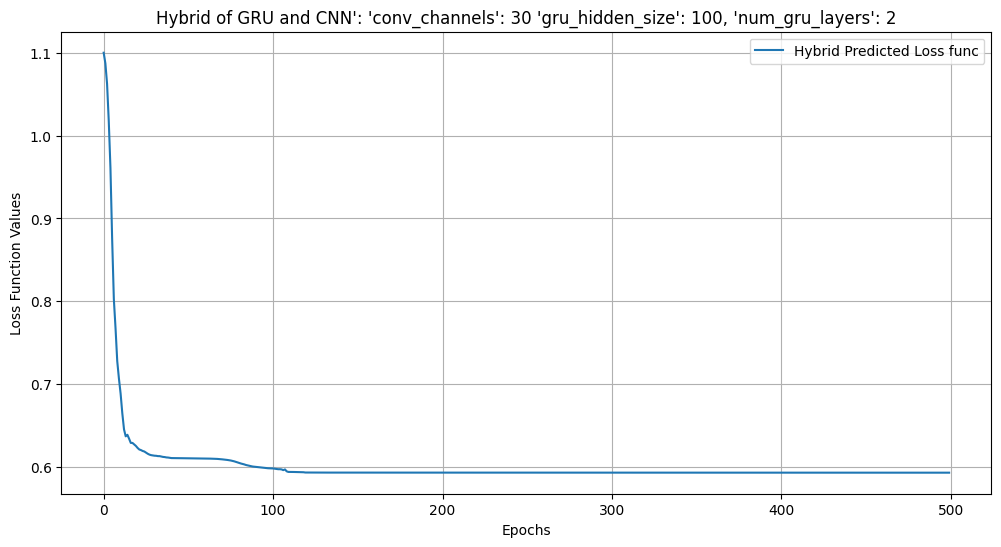

------------------------- for conv_channels = 35-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.0955
Epoch [51/500], Loss: 0.6200
Epoch [101/500], Loss: 0.6172
Epoch [151/500], Loss: 0.6172
Epoch [201/500], Loss: 0.6172
Epoch [251/500], Loss: 0.6172
Epoch [301/500], Loss: 0.6172
Epoch [351/500], Loss: 0.6172
Epoch [401/500], Loss: 0.6172
Epoch [451/500], Loss: 0.6172


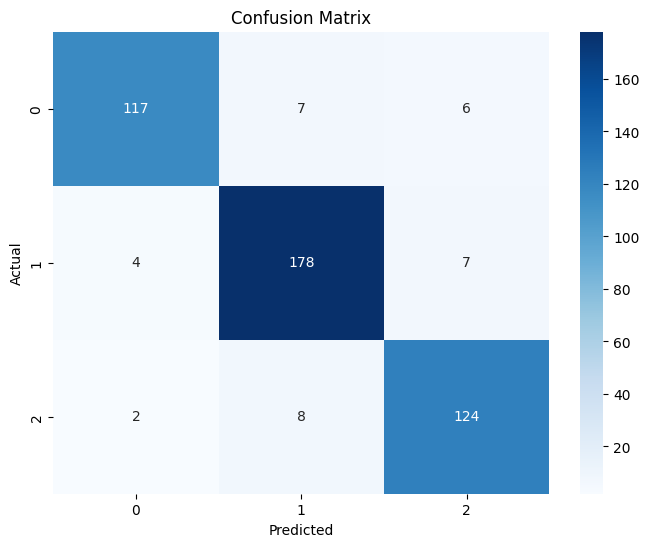

Hybrid of GRU and CNN Accuracy: 0.9249448123620309
Hybrid of GRU and CNN Confusion Matrix:
[[117   7   6]
 [  4 178   7]
 [  2   8 124]]
Hybrid of GRU and CNN Precision: 0.9255057151152938
Hybrid of GRU and CNN Recall: 0.9249448123620309
Hybrid of GRU and CNN F1 Score: 0.9249461061318116
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       130
           1       0.92      0.94      0.93       189
           2       0.91      0.93      0.92       134

    accuracy                           0.92       453
   macro avg       0.93      0.92      0.92       453
weighted avg       0.93      0.92      0.92       453



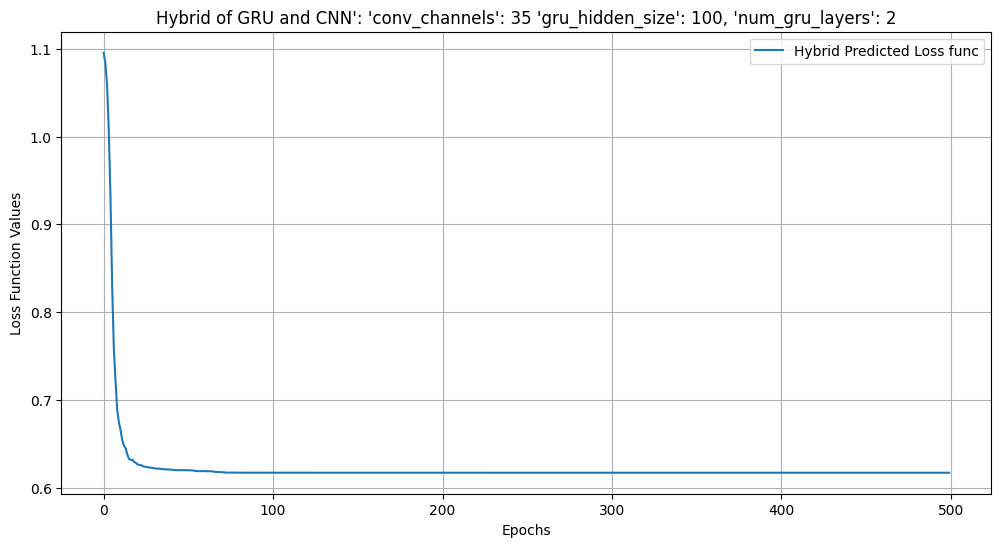

------------------------- for conv_channels = 40-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.1018
Epoch [51/500], Loss: 0.6075
Epoch [101/500], Loss: 0.5874
Epoch [151/500], Loss: 0.5874
Epoch [201/500], Loss: 0.5874
Epoch [251/500], Loss: 0.5835
Epoch [301/500], Loss: 0.5826
Epoch [351/500], Loss: 0.5825
Epoch [401/500], Loss: 0.5824
Epoch [451/500], Loss: 0.5824


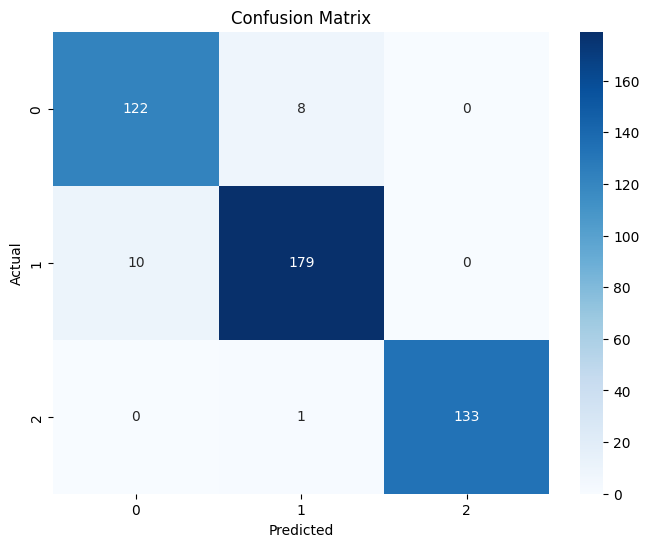

Hybrid of GRU and CNN Accuracy: 0.9580573951434879
Hybrid of GRU and CNN Confusion Matrix:
[[122   8   0]
 [ 10 179   0]
 [  0   1 133]]
Hybrid of GRU and CNN Precision: 0.9582861872209484
Hybrid of GRU and CNN Recall: 0.9580573951434879
Hybrid of GRU and CNN F1 Score: 0.9581492951256253
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       130
           1       0.95      0.95      0.95       189
           2       1.00      0.99      1.00       134

    accuracy                           0.96       453
   macro avg       0.96      0.96      0.96       453
weighted avg       0.96      0.96      0.96       453



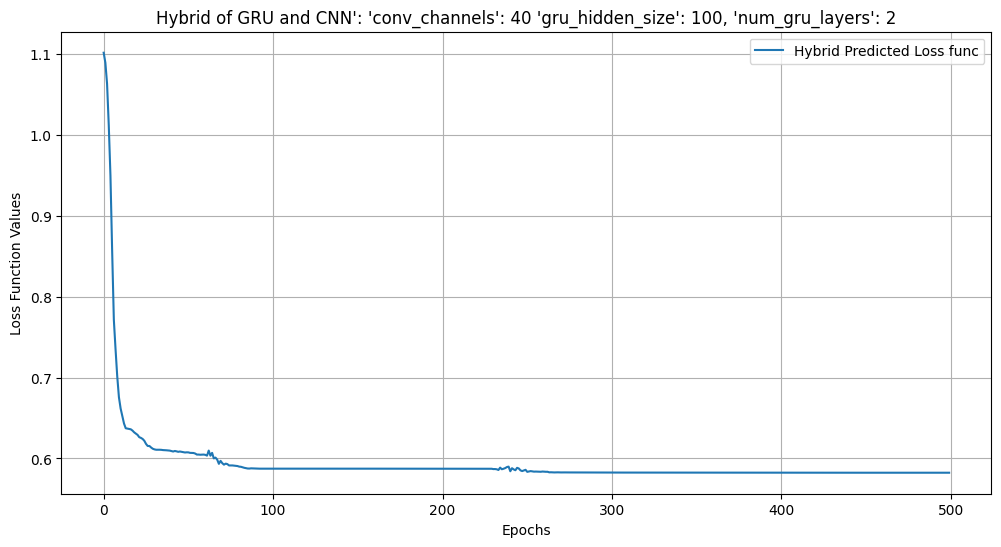

------------------------- for conv_channels = 45-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.0987
Epoch [51/500], Loss: 0.6084
Epoch [101/500], Loss: 0.6078
Epoch [151/500], Loss: 0.6078
Epoch [201/500], Loss: 0.6070
Epoch [251/500], Loss: 0.5923
Epoch [301/500], Loss: 0.5832
Epoch [351/500], Loss: 0.5825
Epoch [401/500], Loss: 0.5824
Epoch [451/500], Loss: 0.5824


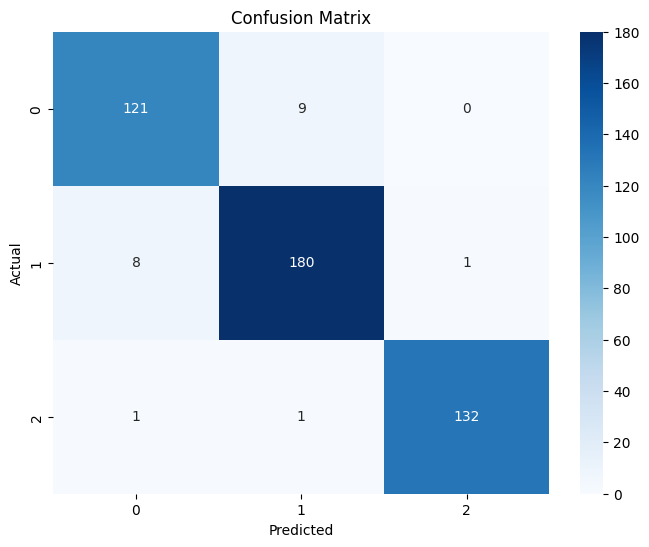

Hybrid of GRU and CNN Accuracy: 0.9558498896247241
Hybrid of GRU and CNN Confusion Matrix:
[[121   9   0]
 [  8 180   1]
 [  1   1 132]]
Hybrid of GRU and CNN Precision: 0.9559494763398563
Hybrid of GRU and CNN Recall: 0.9558498896247241
Hybrid of GRU and CNN F1 Score: 0.9558928211601161
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       130
           1       0.95      0.95      0.95       189
           2       0.99      0.99      0.99       134

    accuracy                           0.96       453
   macro avg       0.96      0.96      0.96       453
weighted avg       0.96      0.96      0.96       453



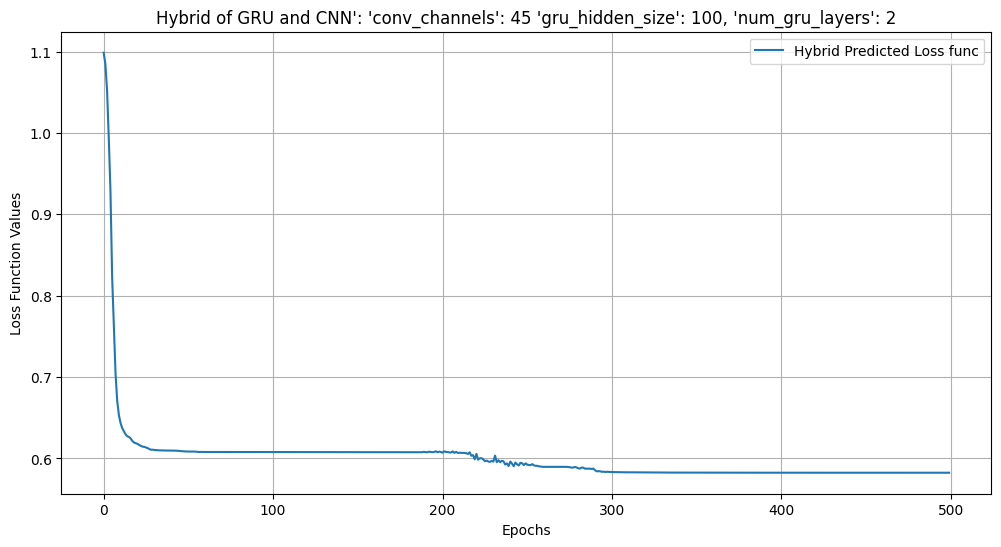

------------------------- for conv_channels = 50-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.1026
Epoch [51/500], Loss: 0.6092
Epoch [101/500], Loss: 0.6078
Epoch [151/500], Loss: 0.6078
Epoch [201/500], Loss: 0.6078
Epoch [251/500], Loss: 0.6078
Epoch [301/500], Loss: 0.6078
Epoch [351/500], Loss: 0.6078
Epoch [401/500], Loss: 0.6078
Epoch [451/500], Loss: 0.6078


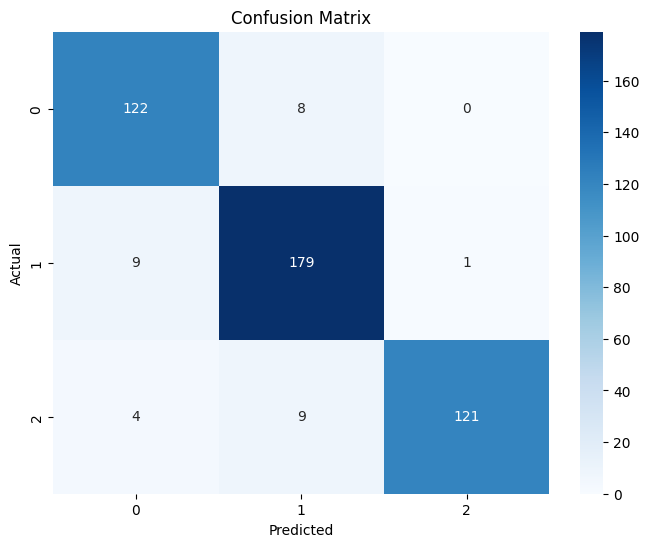

Hybrid of GRU and CNN Accuracy: 0.9315673289183223
Hybrid of GRU and CNN Confusion Matrix:
[[122   8   0]
 [  9 179   1]
 [  4   9 121]]
Hybrid of GRU and CNN Precision: 0.9337533414633259
Hybrid of GRU and CNN Recall: 0.9315673289183223
Hybrid of GRU and CNN F1 Score: 0.9318221694326748
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       130
           1       0.91      0.95      0.93       189
           2       0.99      0.90      0.95       134

    accuracy                           0.93       453
   macro avg       0.94      0.93      0.93       453
weighted avg       0.93      0.93      0.93       453



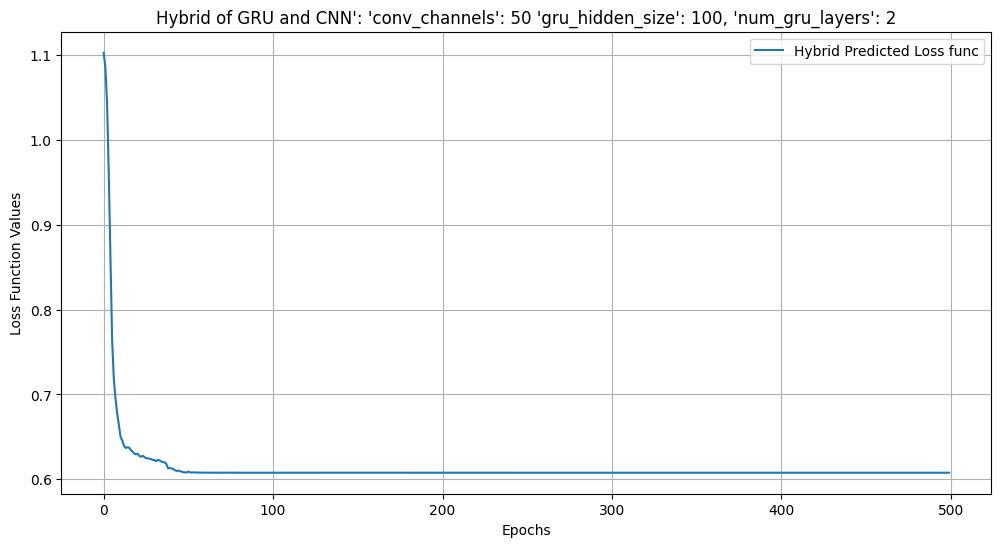

------------------------- for conv_channels = 55-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.1050
Epoch [51/500], Loss: 0.6228
Epoch [101/500], Loss: 0.6189
Epoch [151/500], Loss: 0.6189
Epoch [201/500], Loss: 0.6189
Epoch [251/500], Loss: 0.6189
Epoch [301/500], Loss: 0.6183
Epoch [351/500], Loss: 0.6183
Epoch [401/500], Loss: 0.6183
Epoch [451/500], Loss: 0.6183


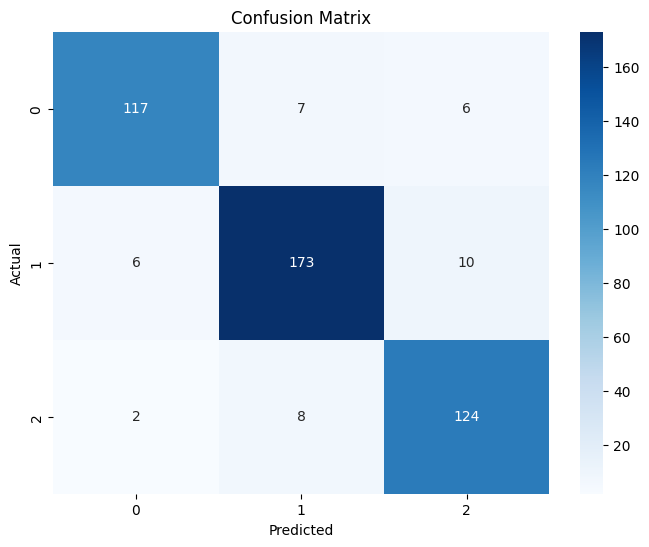

Hybrid of GRU and CNN Accuracy: 0.9139072847682119
Hybrid of GRU and CNN Confusion Matrix:
[[117   7   6]
 [  6 173  10]
 [  2   8 124]]
Hybrid of GRU and CNN Precision: 0.914538470312741
Hybrid of GRU and CNN Recall: 0.9139072847682119
Hybrid of GRU and CNN F1 Score: 0.9139904528069539
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       130
           1       0.92      0.92      0.92       189
           2       0.89      0.93      0.91       134

    accuracy                           0.91       453
   macro avg       0.91      0.91      0.91       453
weighted avg       0.91      0.91      0.91       453



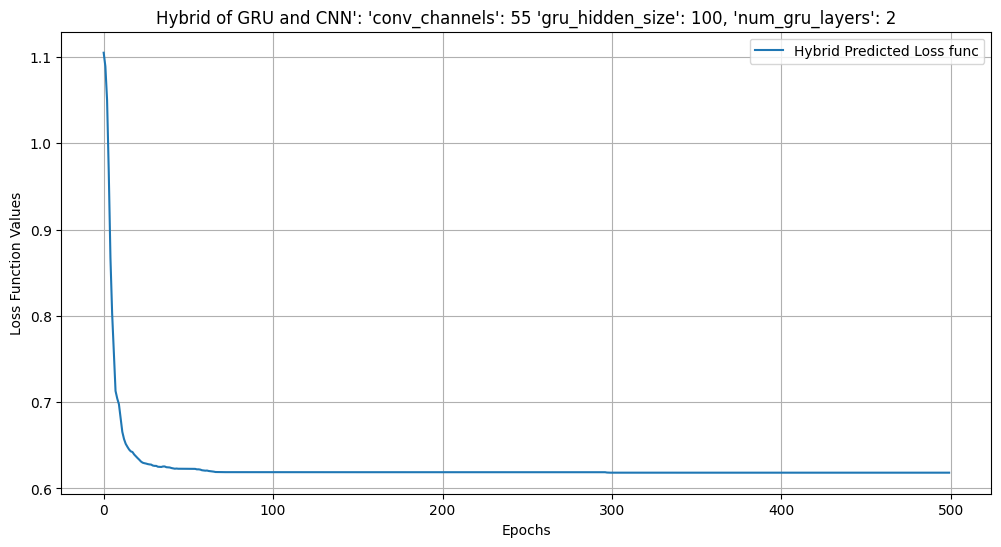

------------------------- for conv_channels = 60-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.1035
Epoch [51/500], Loss: 0.6196
Epoch [101/500], Loss: 0.6194
Epoch [151/500], Loss: 0.5865
Epoch [201/500], Loss: 0.5826
Epoch [251/500], Loss: 0.5825
Epoch [301/500], Loss: 0.5825
Epoch [351/500], Loss: 0.5825
Epoch [401/500], Loss: 0.5825
Epoch [451/500], Loss: 0.5825


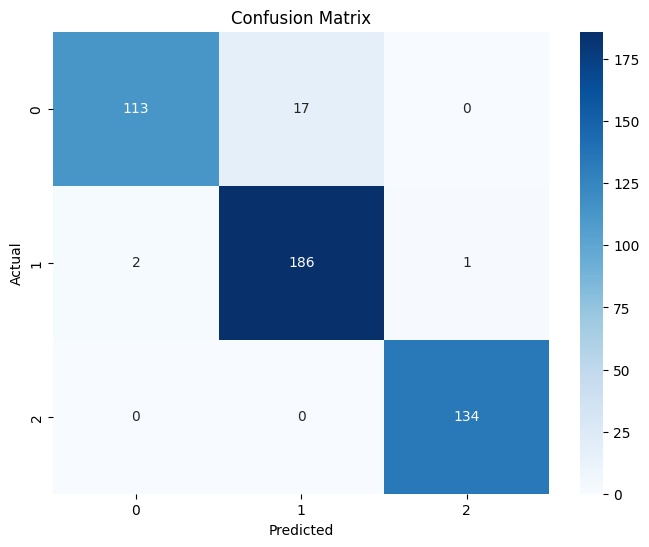

Hybrid of GRU and CNN Accuracy: 0.9558498896247241
Hybrid of GRU and CNN Confusion Matrix:
[[113  17   0]
 [  2 186   1]
 [  0   0 134]]
Hybrid of GRU and CNN Precision: 0.9578784804311115
Hybrid of GRU and CNN Recall: 0.9558498896247241
Hybrid of GRU and CNN F1 Score: 0.9553584303314372
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       130
           1       0.92      0.98      0.95       189
           2       0.99      1.00      1.00       134

    accuracy                           0.96       453
   macro avg       0.96      0.95      0.96       453
weighted avg       0.96      0.96      0.96       453



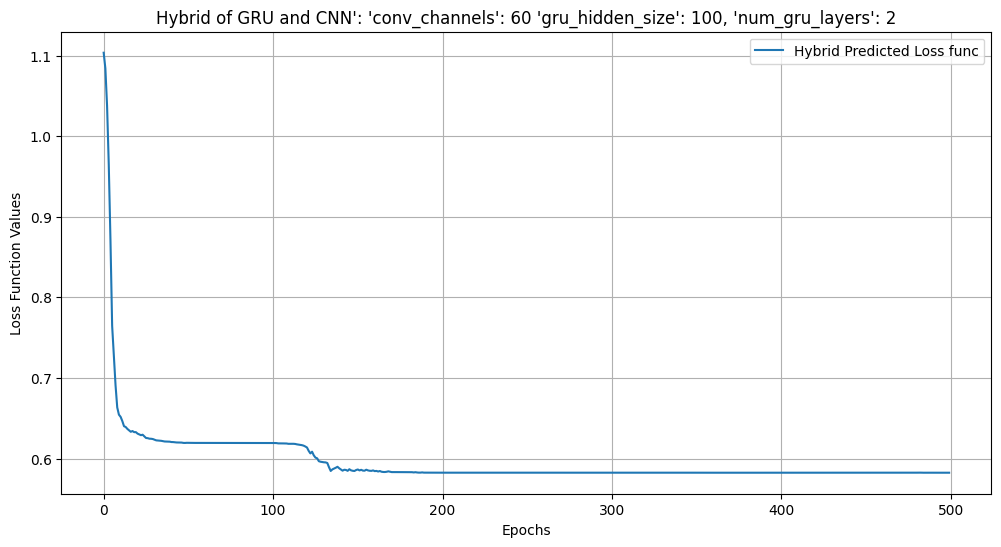

------------------------- for conv_channels = 65-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.1042
Epoch [51/500], Loss: 0.6221
Epoch [101/500], Loss: 0.6189
Epoch [151/500], Loss: 0.5882
Epoch [201/500], Loss: 0.5828
Epoch [251/500], Loss: 0.5821
Epoch [301/500], Loss: 0.5821
Epoch [351/500], Loss: 0.5821
Epoch [401/500], Loss: 0.5822
Epoch [451/500], Loss: 0.5821


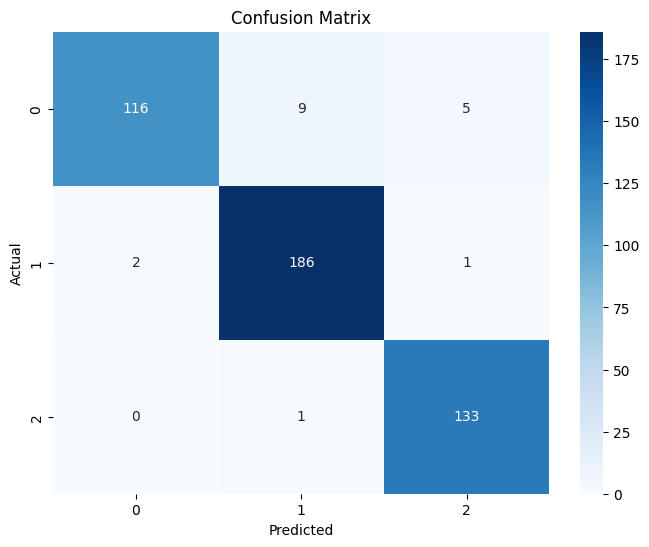

Hybrid of GRU and CNN Accuracy: 0.9602649006622517
Hybrid of GRU and CNN Confusion Matrix:
[[116   9   5]
 [  2 186   1]
 [  0   1 133]]
Hybrid of GRU and CNN Precision: 0.9610807513570947
Hybrid of GRU and CNN Recall: 0.9602649006622517
Hybrid of GRU and CNN F1 Score: 0.9598127761768009
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.94       130
           1       0.95      0.98      0.97       189
           2       0.96      0.99      0.97       134

    accuracy                           0.96       453
   macro avg       0.96      0.96      0.96       453
weighted avg       0.96      0.96      0.96       453



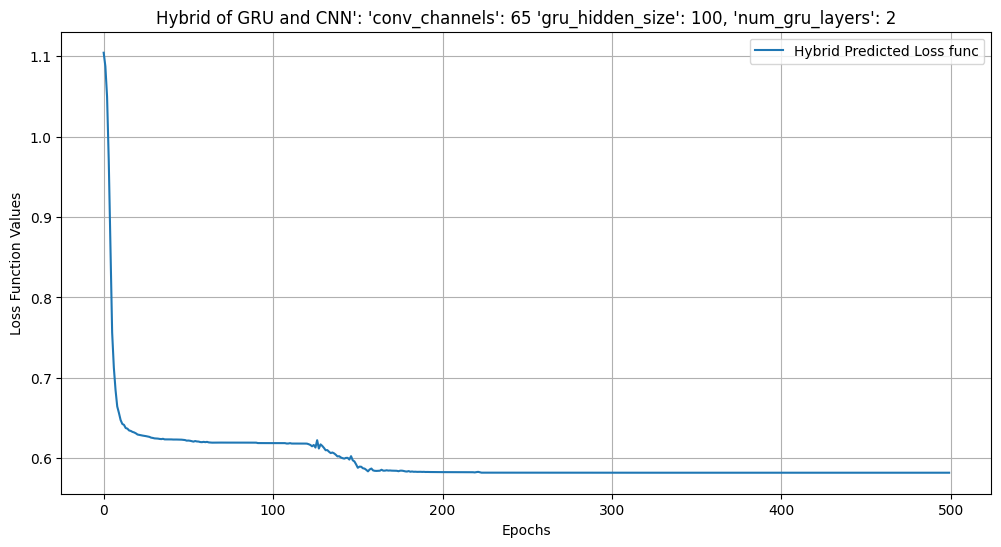

------------------------- for conv_channels = 70-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.1045
Epoch [51/500], Loss: 0.6101
Epoch [101/500], Loss: 0.5959
Epoch [151/500], Loss: 0.5940
Epoch [201/500], Loss: 0.5940
Epoch [251/500], Loss: 0.5940
Epoch [301/500], Loss: 0.5940
Epoch [351/500], Loss: 0.5940
Epoch [401/500], Loss: 0.5940
Epoch [451/500], Loss: 0.5940


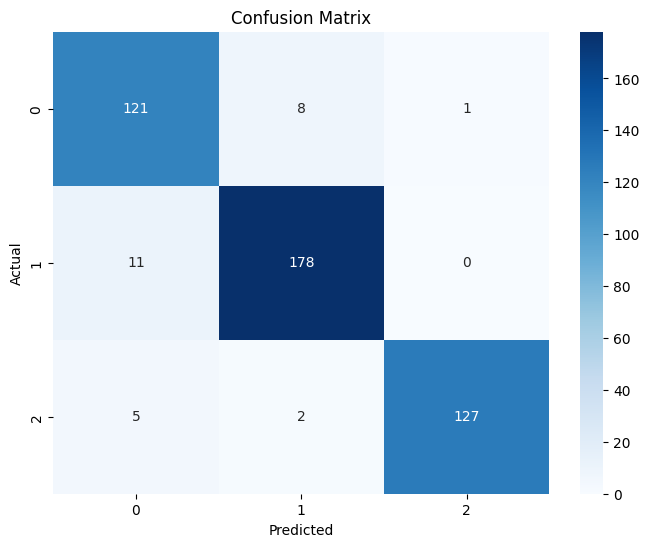

Hybrid of GRU and CNN Accuracy: 0.9403973509933775
Hybrid of GRU and CNN Confusion Matrix:
[[121   8   1]
 [ 11 178   0]
 [  5   2 127]]
Hybrid of GRU and CNN Precision: 0.941981129710405
Hybrid of GRU and CNN Recall: 0.9403973509933775
Hybrid of GRU and CNN F1 Score: 0.9408570879547112
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       130
           1       0.95      0.94      0.94       189
           2       0.99      0.95      0.97       134

    accuracy                           0.94       453
   macro avg       0.94      0.94      0.94       453
weighted avg       0.94      0.94      0.94       453



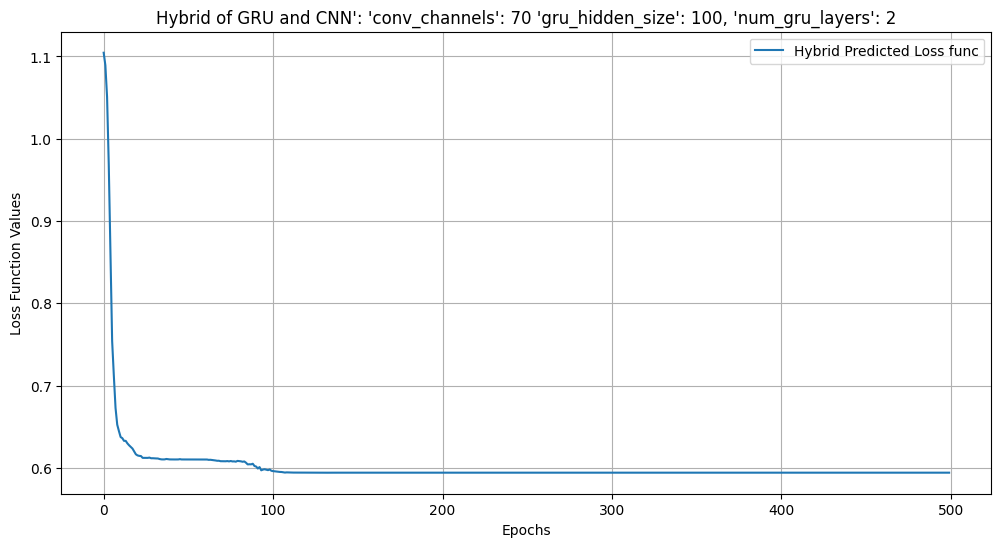

------------------------- for conv_channels = 75-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.0996
Epoch [51/500], Loss: 0.6102
Epoch [101/500], Loss: 0.6012
Epoch [151/500], Loss: 0.5744
Epoch [201/500], Loss: 0.5719
Epoch [251/500], Loss: 0.5714
Epoch [301/500], Loss: 0.5708
Epoch [351/500], Loss: 0.5708
Epoch [401/500], Loss: 0.5708
Epoch [451/500], Loss: 0.5708


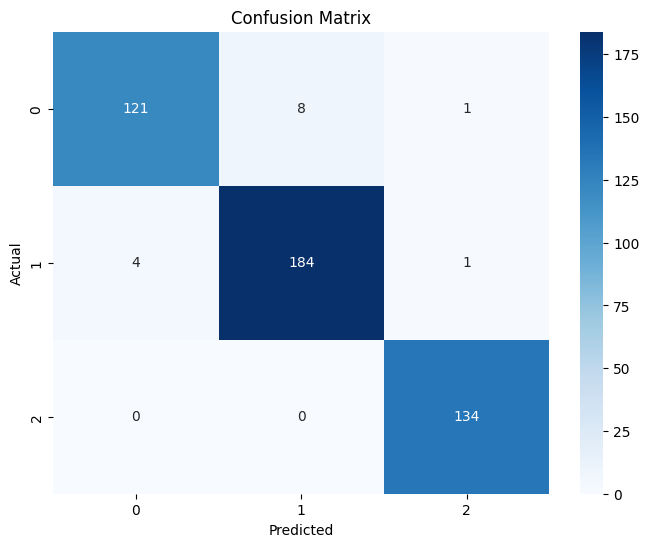

Hybrid of GRU and CNN Accuracy: 0.9690949227373068
Hybrid of GRU and CNN Confusion Matrix:
[[121   8   1]
 [  4 184   1]
 [  0   0 134]]
Hybrid of GRU and CNN Precision: 0.9690825866770549
Hybrid of GRU and CNN Recall: 0.9690949227373068
Hybrid of GRU and CNN F1 Score: 0.9689429084533718
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       130
           1       0.96      0.97      0.97       189
           2       0.99      1.00      0.99       134

    accuracy                           0.97       453
   macro avg       0.97      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453



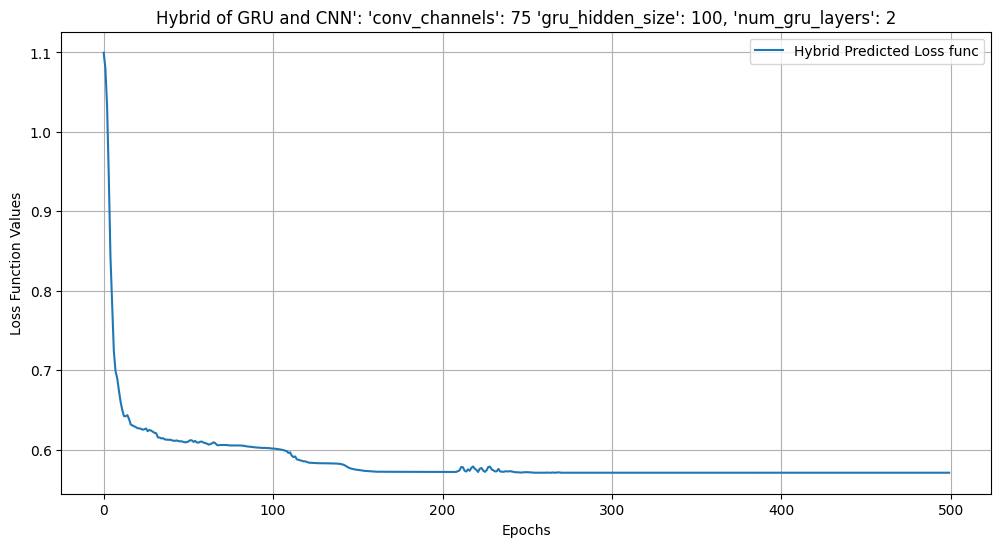

------------------------- for conv_channels = 80-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.0987
Epoch [51/500], Loss: 0.6073
Epoch [101/500], Loss: 0.5810
Epoch [151/500], Loss: 0.5714
Epoch [201/500], Loss: 0.5712
Epoch [251/500], Loss: 0.5614
Epoch [301/500], Loss: 0.5614
Epoch [351/500], Loss: 0.5614
Epoch [401/500], Loss: 0.5614
Epoch [451/500], Loss: 0.5614


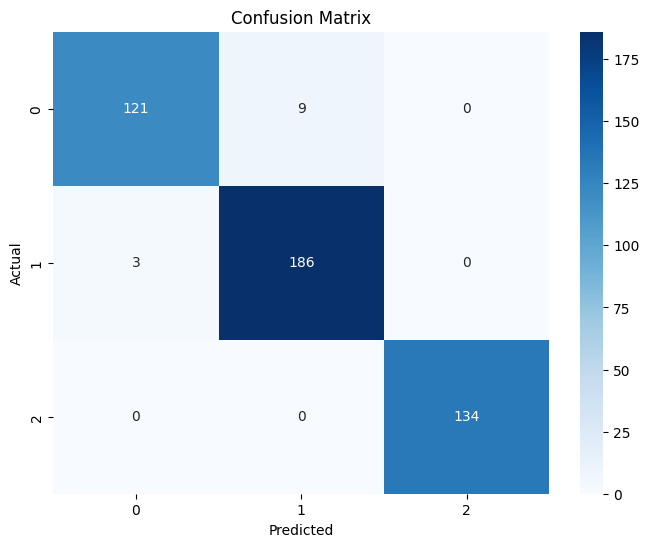

Hybrid of GRU and CNN Accuracy: 0.9735099337748344
Hybrid of GRU and CNN Confusion Matrix:
[[121   9   0]
 [  3 186   0]
 [  0   0 134]]
Hybrid of GRU and CNN Precision: 0.9738007986459173
Hybrid of GRU and CNN Recall: 0.9735099337748344
Hybrid of GRU and CNN F1 Score: 0.9734040126192834
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       130
           1       0.95      0.98      0.97       189
           2       1.00      1.00      1.00       134

    accuracy                           0.97       453
   macro avg       0.98      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453



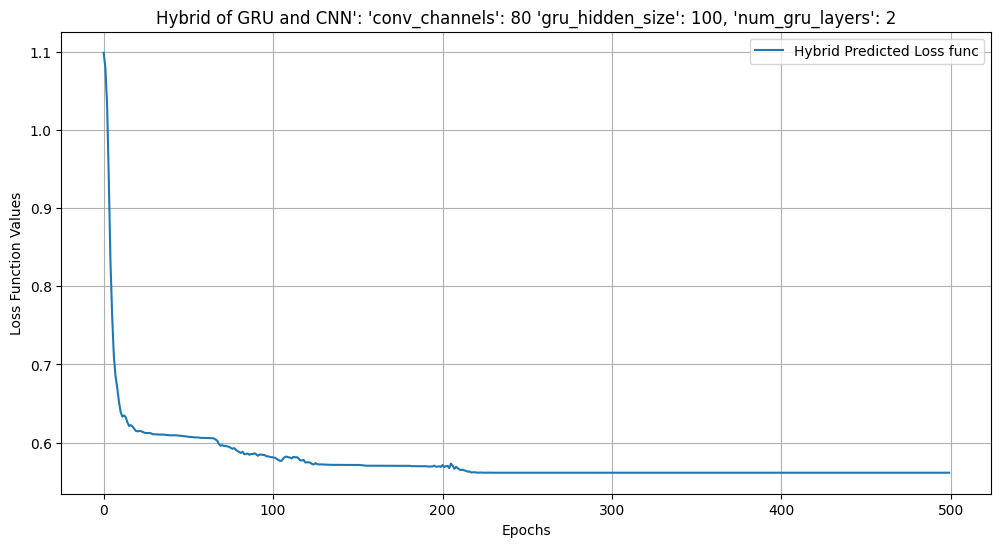

------------------------- for conv_channels = 85-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.1007
Epoch [51/500], Loss: 0.6113
Epoch [101/500], Loss: 0.6111
Epoch [151/500], Loss: 0.6111
Epoch [201/500], Loss: 0.6111
Epoch [251/500], Loss: 0.6111
Epoch [301/500], Loss: 0.6183
Epoch [351/500], Loss: 0.5997
Epoch [401/500], Loss: 0.5726
Epoch [451/500], Loss: 0.5635


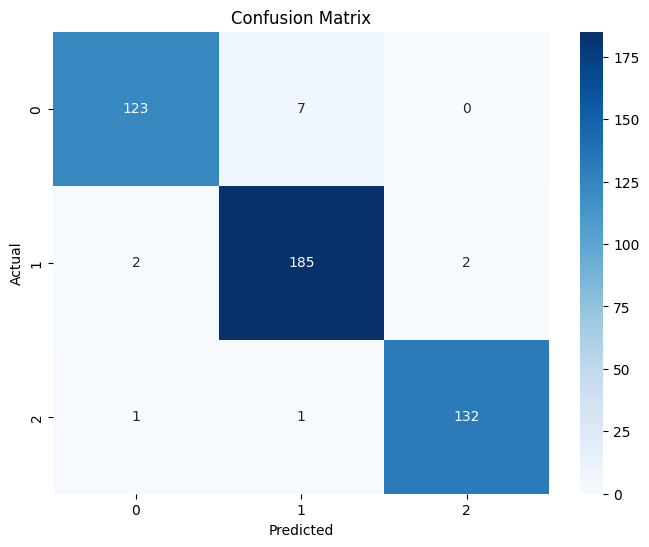

Hybrid of GRU and CNN Accuracy: 0.9713024282560706
Hybrid of GRU and CNN Confusion Matrix:
[[123   7   0]
 [  2 185   2]
 [  1   1 132]]
Hybrid of GRU and CNN Precision: 0.9714582009129585
Hybrid of GRU and CNN Recall: 0.9713024282560706
Hybrid of GRU and CNN F1 Score: 0.9712686583336222
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       130
           1       0.96      0.98      0.97       189
           2       0.99      0.99      0.99       134

    accuracy                           0.97       453
   macro avg       0.97      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453



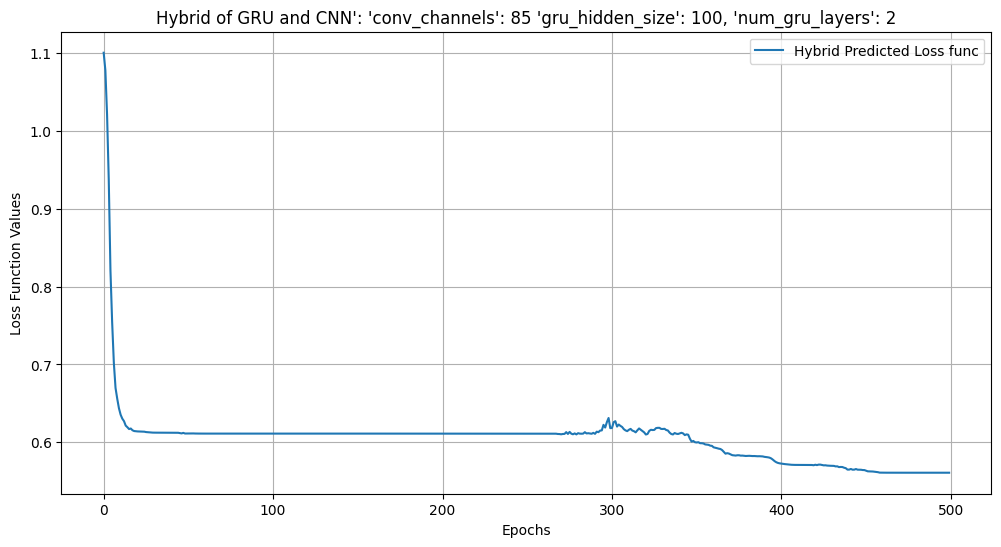

------------------------- for conv_channels = 90-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.1001
Epoch [51/500], Loss: 0.5845
Epoch [101/500], Loss: 0.5689
Epoch [151/500], Loss: 0.5626
Epoch [201/500], Loss: 0.5626
Epoch [251/500], Loss: 0.5625
Epoch [301/500], Loss: 0.5620
Epoch [351/500], Loss: 0.5620
Epoch [401/500], Loss: 0.5620
Epoch [451/500], Loss: 0.5620


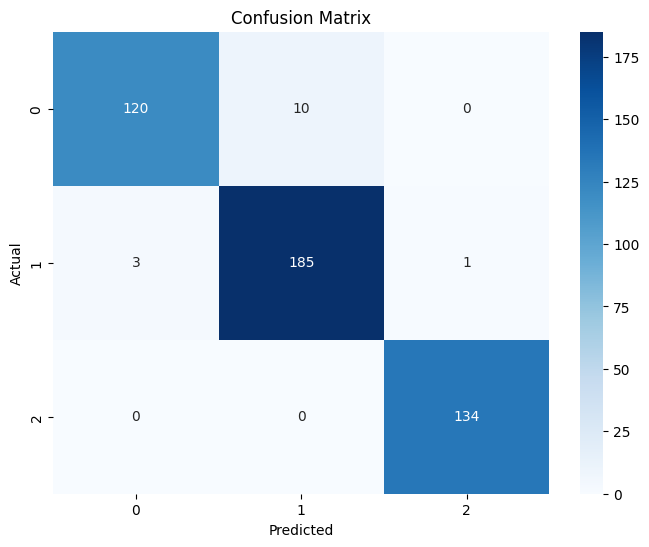

Hybrid of GRU and CNN Accuracy: 0.9690949227373068
Hybrid of GRU and CNN Confusion Matrix:
[[120  10   0]
 [  3 185   1]
 [  0   0 134]]
Hybrid of GRU and CNN Precision: 0.96941361591122
Hybrid of GRU and CNN Recall: 0.9690949227373068
Hybrid of GRU and CNN F1 Score: 0.9689434698428837
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       130
           1       0.95      0.98      0.96       189
           2       0.99      1.00      1.00       134

    accuracy                           0.97       453
   macro avg       0.97      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453



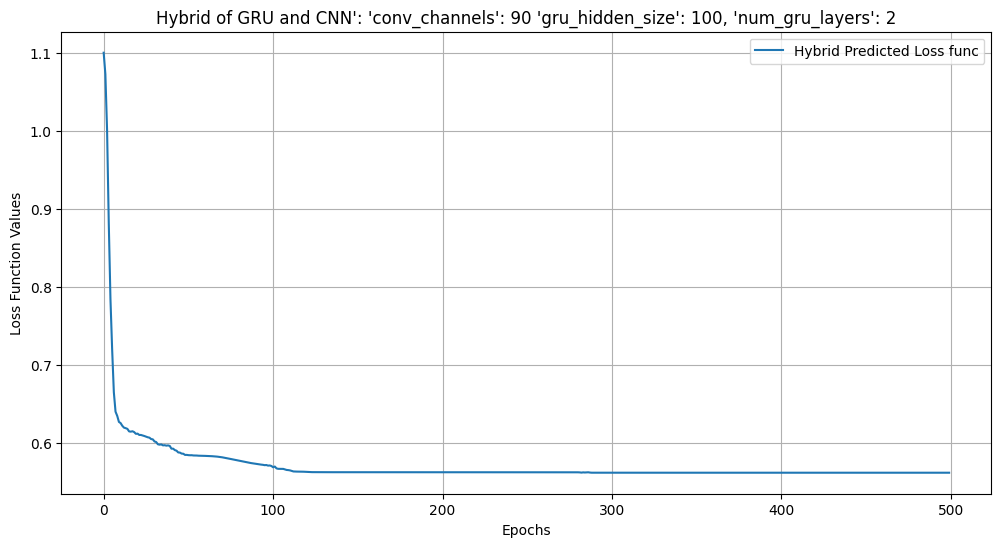

------------------------- for conv_channels = 95-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.0945
Epoch [51/500], Loss: 0.6038
Epoch [101/500], Loss: 0.5828
Epoch [151/500], Loss: 0.5827
Epoch [201/500], Loss: 0.5827
Epoch [251/500], Loss: 0.5826
Epoch [301/500], Loss: 0.5826
Epoch [351/500], Loss: 0.5824
Epoch [401/500], Loss: 0.5824
Epoch [451/500], Loss: 0.5824


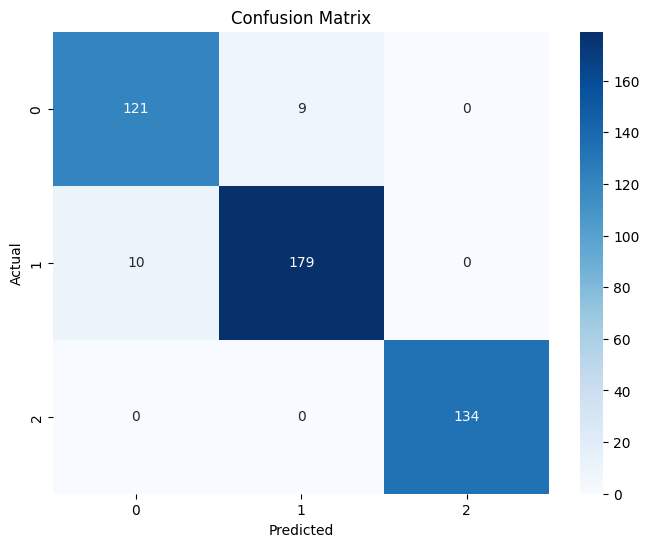

Hybrid of GRU and CNN Accuracy: 0.9580573951434879
Hybrid of GRU and CNN Confusion Matrix:
[[121   9   0]
 [ 10 179   0]
 [  0   0 134]]
Hybrid of GRU and CNN Precision: 0.9581202285594637
Hybrid of GRU and CNN Recall: 0.9580573951434879
Hybrid of GRU and CNN F1 Score: 0.9580821181643286
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       130
           1       0.95      0.95      0.95       189
           2       1.00      1.00      1.00       134

    accuracy                           0.96       453
   macro avg       0.96      0.96      0.96       453
weighted avg       0.96      0.96      0.96       453



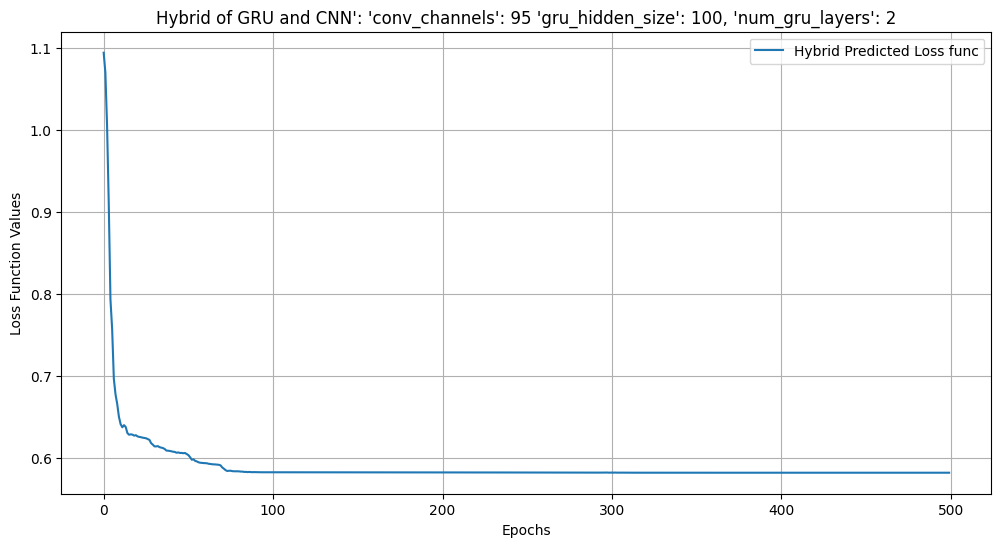

------------------------- for conv_channels = 100-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.0972
Epoch [51/500], Loss: 0.6063
Epoch [101/500], Loss: 0.5828
Epoch [151/500], Loss: 0.5824
Epoch [201/500], Loss: 0.5824
Epoch [251/500], Loss: 0.5823
Epoch [301/500], Loss: 0.5654
Epoch [351/500], Loss: 0.5616
Epoch [401/500], Loss: 0.5614
Epoch [451/500], Loss: 0.5614


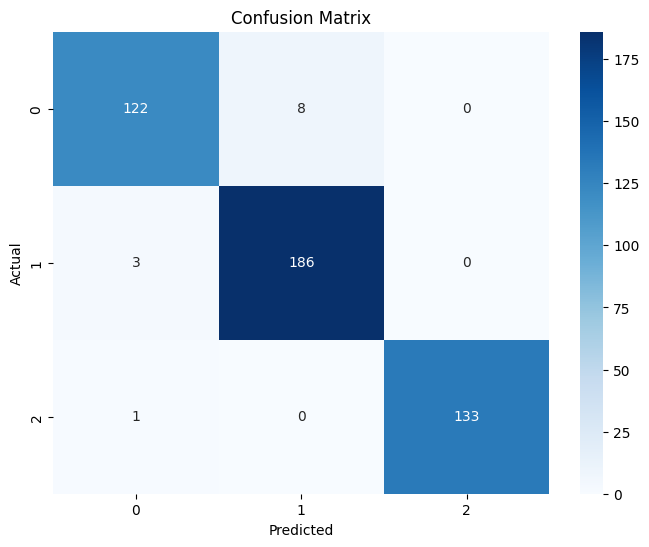

Hybrid of GRU and CNN Accuracy: 0.9735099337748344
Hybrid of GRU and CNN Confusion Matrix:
[[122   8   0]
 [  3 186   0]
 [  1   0 133]]
Hybrid of GRU and CNN Precision: 0.9736847713907862
Hybrid of GRU and CNN Recall: 0.9735099337748344
Hybrid of GRU and CNN F1 Score: 0.973457348581465
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       130
           1       0.96      0.98      0.97       189
           2       1.00      0.99      1.00       134

    accuracy                           0.97       453
   macro avg       0.98      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453



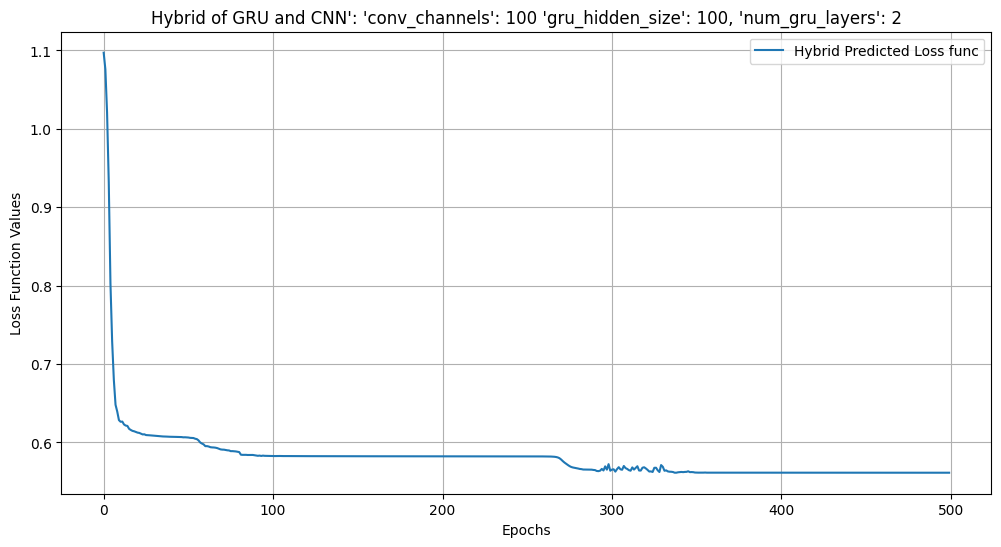

------------------------- for conv_channels = 105-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.0987
Epoch [51/500], Loss: 0.6100
Epoch [101/500], Loss: 0.5876
Epoch [151/500], Loss: 0.5881
Epoch [201/500], Loss: 0.5829
Epoch [251/500], Loss: 0.5605
Epoch [301/500], Loss: 0.5603
Epoch [351/500], Loss: 0.5603
Epoch [401/500], Loss: 0.5603
Epoch [451/500], Loss: 0.5603


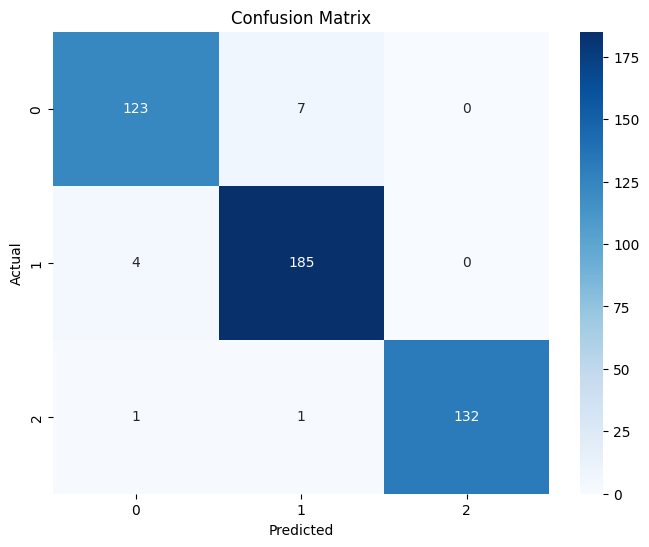

Hybrid of GRU and CNN Accuracy: 0.9713024282560706
Hybrid of GRU and CNN Confusion Matrix:
[[123   7   0]
 [  4 185   0]
 [  1   1 132]]
Hybrid of GRU and CNN Precision: 0.9714959781651397
Hybrid of GRU and CNN Recall: 0.9713024282560706
Hybrid of GRU and CNN F1 Score: 0.9713218472411289
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       130
           1       0.96      0.98      0.97       189
           2       1.00      0.99      0.99       134

    accuracy                           0.97       453
   macro avg       0.97      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453



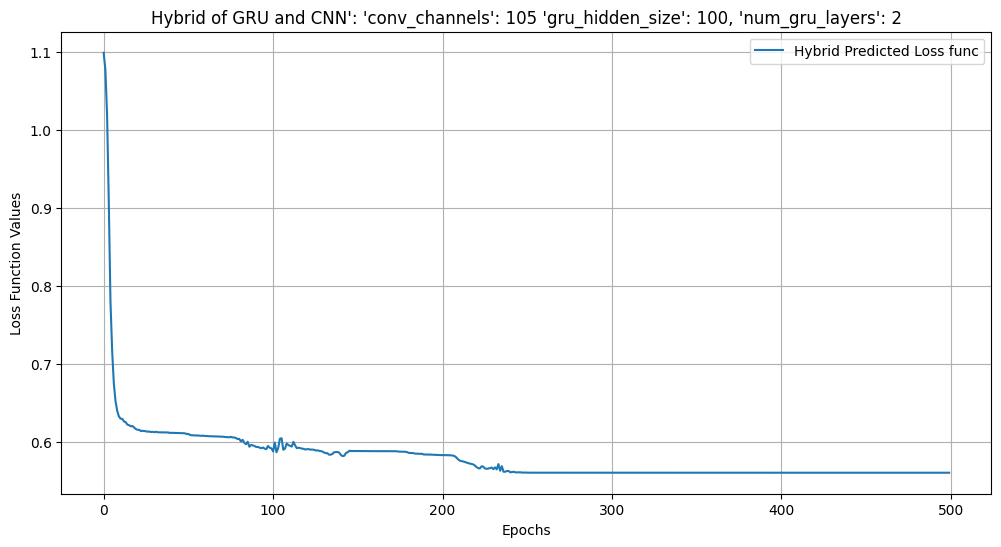

------------------------- for conv_channels = 110-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.0954
Epoch [51/500], Loss: 0.5923
Epoch [101/500], Loss: 0.5839
Epoch [151/500], Loss: 0.5832
Epoch [201/500], Loss: 0.5832
Epoch [251/500], Loss: 0.5830
Epoch [301/500], Loss: 0.5829
Epoch [351/500], Loss: 0.5829
Epoch [401/500], Loss: 0.5829
Epoch [451/500], Loss: 0.5829


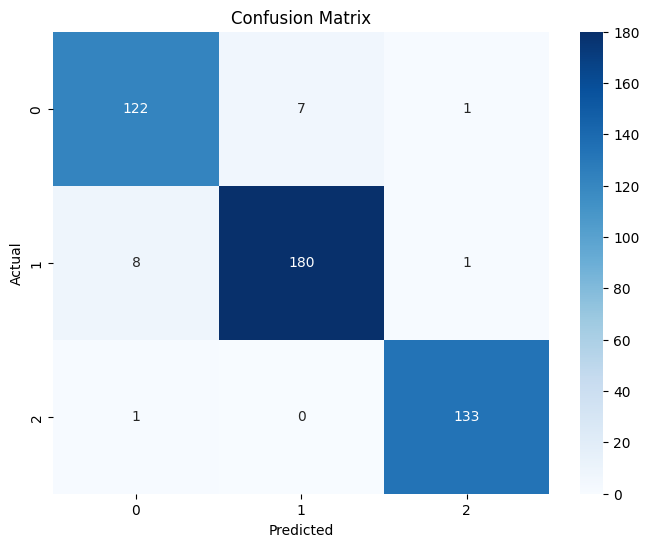

Hybrid of GRU and CNN Accuracy: 0.9602649006622517
Hybrid of GRU and CNN Confusion Matrix:
[[122   7   1]
 [  8 180   1]
 [  1   0 133]]
Hybrid of GRU and CNN Precision: 0.9602839973393613
Hybrid of GRU and CNN Recall: 0.9602649006622517
Hybrid of GRU and CNN F1 Score: 0.9602551657097075
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       130
           1       0.96      0.95      0.96       189
           2       0.99      0.99      0.99       134

    accuracy                           0.96       453
   macro avg       0.96      0.96      0.96       453
weighted avg       0.96      0.96      0.96       453



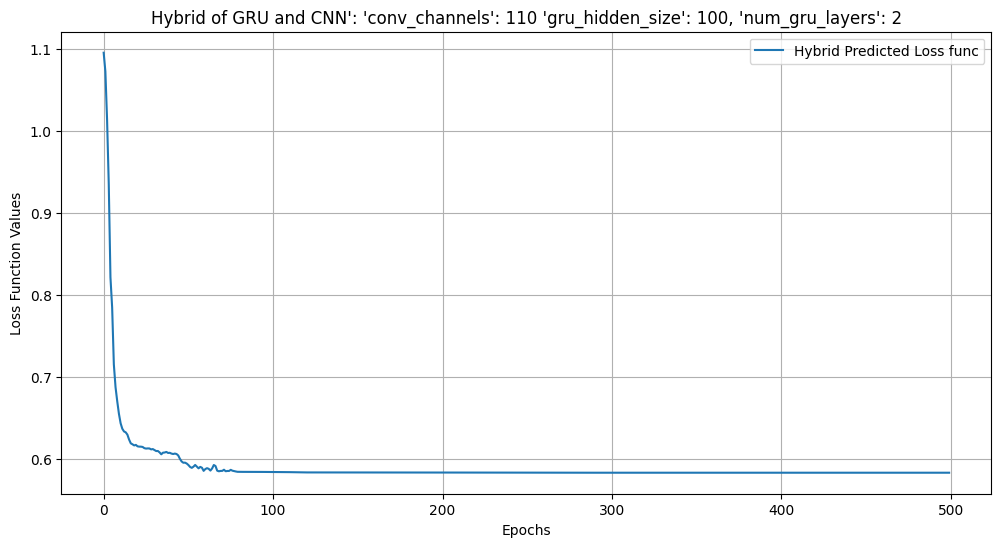

------------------------- for conv_channels = 115-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.1032
Epoch [51/500], Loss: 0.6018
Epoch [101/500], Loss: 0.5833
Epoch [151/500], Loss: 0.5731
Epoch [201/500], Loss: 0.5676
Epoch [251/500], Loss: 0.5623
Epoch [301/500], Loss: 0.5609
Epoch [351/500], Loss: 0.5609
Epoch [401/500], Loss: 0.5609
Epoch [451/500], Loss: 0.5609


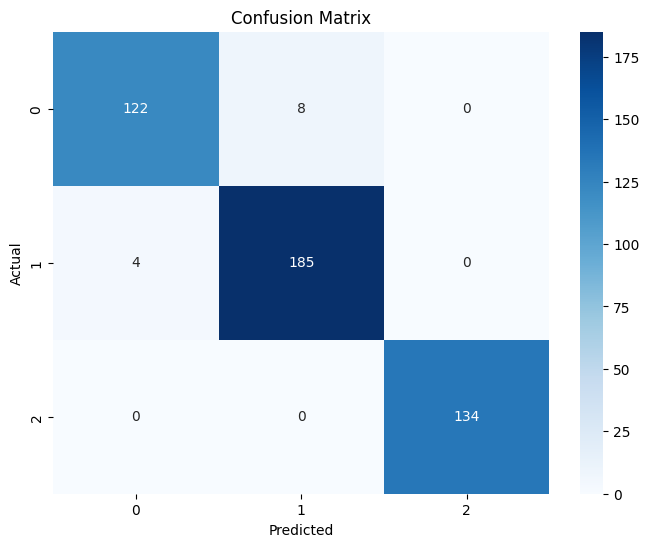

Hybrid of GRU and CNN Accuracy: 0.9735099337748344
Hybrid of GRU and CNN Confusion Matrix:
[[122   8   0]
 [  4 185   0]
 [  0   0 134]]
Hybrid of GRU and CNN Precision: 0.9735956268914442
Hybrid of GRU and CNN Recall: 0.9735099337748344
Hybrid of GRU and CNN F1 Score: 0.9734416715786552
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       130
           1       0.96      0.98      0.97       189
           2       1.00      1.00      1.00       134

    accuracy                           0.97       453
   macro avg       0.98      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453



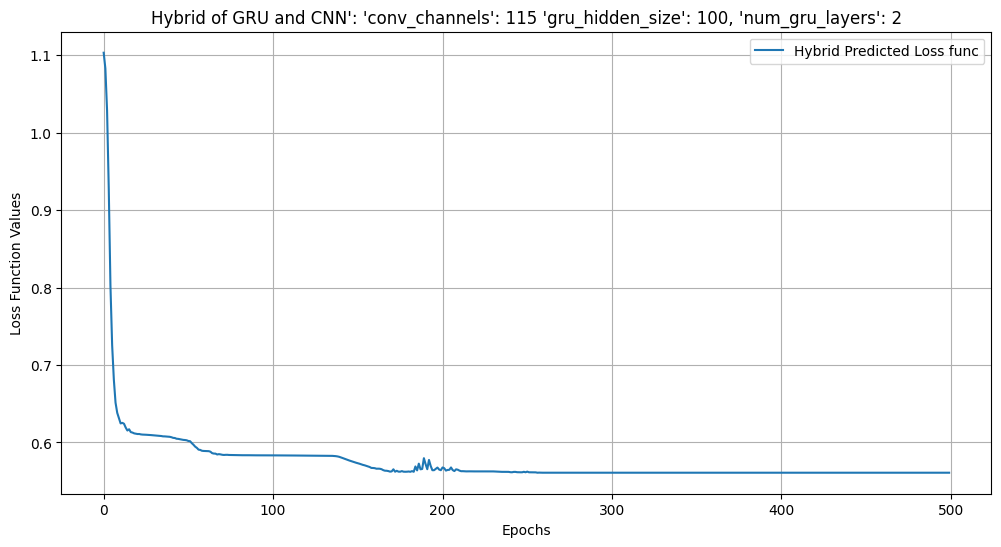

------------------------- for conv_channels = 120-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.0952
Epoch [51/500], Loss: 0.6041
Epoch [101/500], Loss: 0.5821
Epoch [151/500], Loss: 0.5659
Epoch [201/500], Loss: 0.5658
Epoch [251/500], Loss: 0.5658
Epoch [301/500], Loss: 0.5658
Epoch [351/500], Loss: 0.5658
Epoch [401/500], Loss: 0.5658
Epoch [451/500], Loss: 0.5658


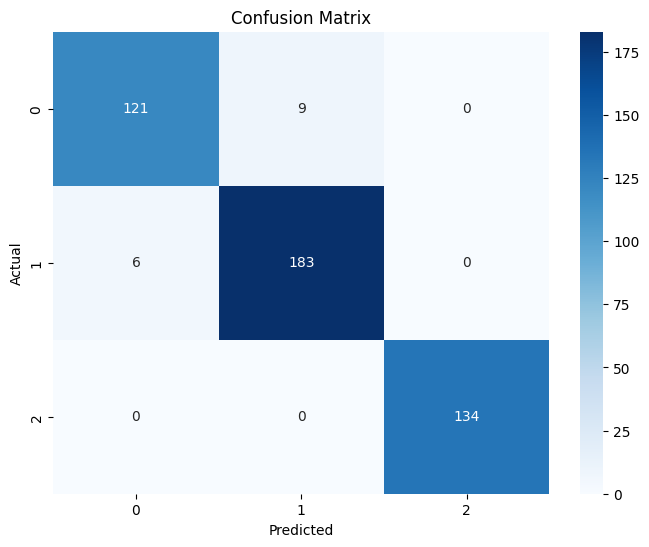

Hybrid of GRU and CNN Accuracy: 0.9668874172185431
Hybrid of GRU and CNN Confusion Matrix:
[[121   9   0]
 [  6 183   0]
 [  0   0 134]]
Hybrid of GRU and CNN Precision: 0.9668849728841842
Hybrid of GRU and CNN Recall: 0.9668874172185431
Hybrid of GRU and CNN F1 Score: 0.9668245176158454
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       130
           1       0.95      0.97      0.96       189
           2       1.00      1.00      1.00       134

    accuracy                           0.97       453
   macro avg       0.97      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453



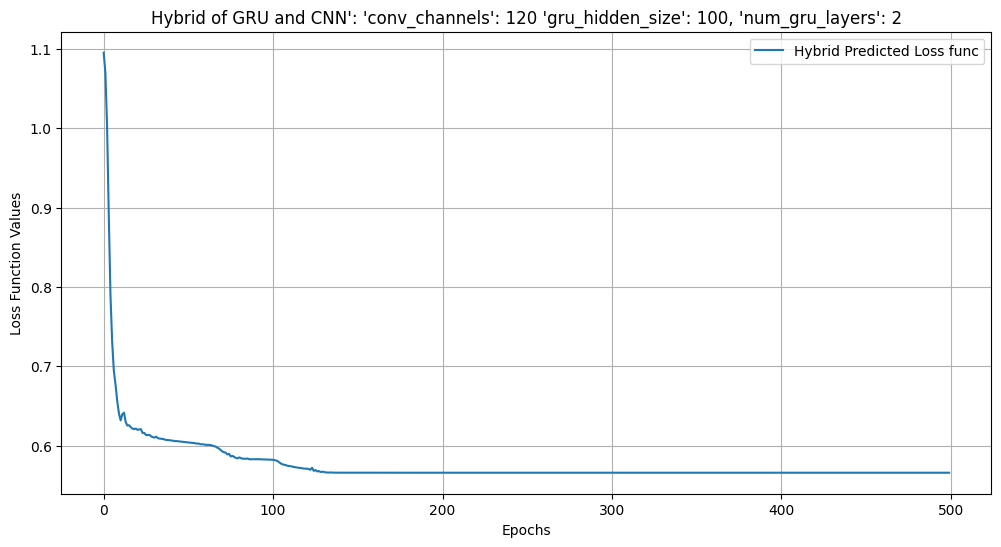

------------------------- for conv_channels = 125-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.0979
Epoch [51/500], Loss: 0.6063
Epoch [101/500], Loss: 0.5828
Epoch [151/500], Loss: 0.5824
Epoch [201/500], Loss: 0.5824
Epoch [251/500], Loss: 0.5824
Epoch [301/500], Loss: 0.5824
Epoch [351/500], Loss: 0.5824
Epoch [401/500], Loss: 0.5824
Epoch [451/500], Loss: 0.5824


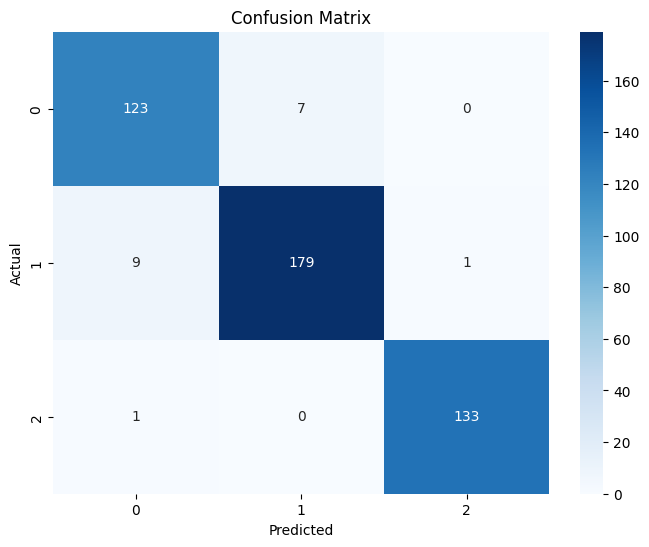

Hybrid of GRU and CNN Accuracy: 0.9602649006622517
Hybrid of GRU and CNN Confusion Matrix:
[[123   7   0]
 [  9 179   1]
 [  1   0 133]]
Hybrid of GRU and CNN Precision: 0.9605135997438587
Hybrid of GRU and CNN Recall: 0.9602649006622517
Hybrid of GRU and CNN F1 Score: 0.9603288259931676
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       130
           1       0.96      0.95      0.95       189
           2       0.99      0.99      0.99       134

    accuracy                           0.96       453
   macro avg       0.96      0.96      0.96       453
weighted avg       0.96      0.96      0.96       453



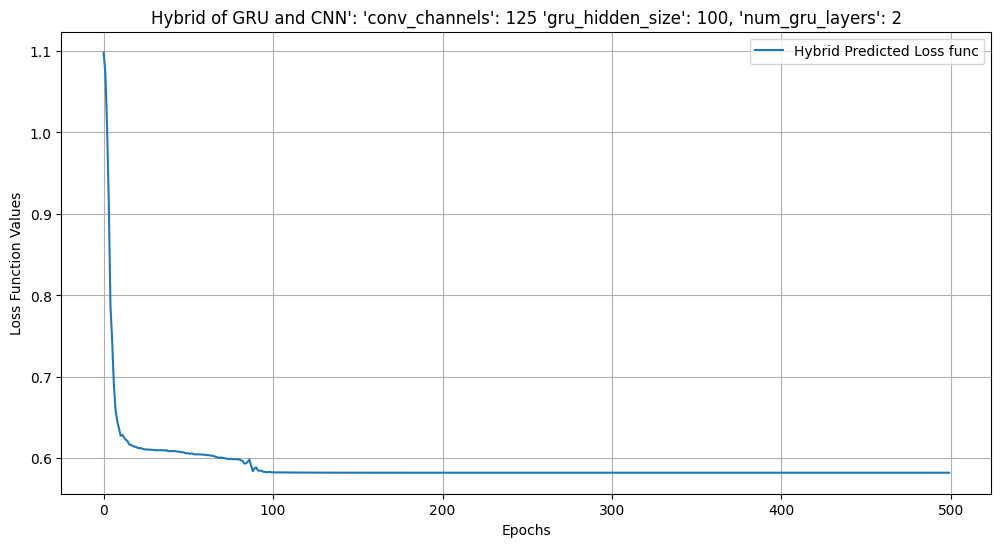

------------------------- for conv_channels = 130-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.1033
Epoch [51/500], Loss: 0.6054
Epoch [101/500], Loss: 0.5878
Epoch [151/500], Loss: 0.5797
Epoch [201/500], Loss: 0.5653
Epoch [251/500], Loss: 0.5614
Epoch [301/500], Loss: 0.5614
Epoch [351/500], Loss: 0.5614
Epoch [401/500], Loss: 0.5614
Epoch [451/500], Loss: 0.5614


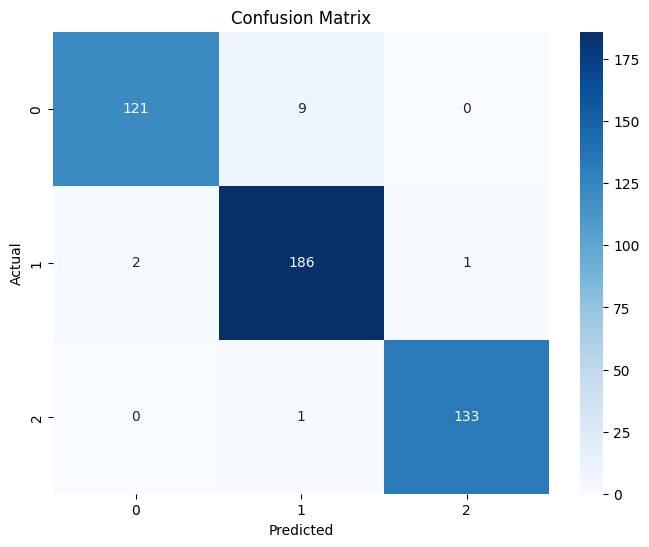

Hybrid of GRU and CNN Accuracy: 0.9713024282560706
Hybrid of GRU and CNN Confusion Matrix:
[[121   9   0]
 [  2 186   1]
 [  0   1 133]]
Hybrid of GRU and CNN Precision: 0.971839562293447
Hybrid of GRU and CNN Recall: 0.9713024282560706
Hybrid of GRU and CNN F1 Score: 0.9712273905190693
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       130
           1       0.95      0.98      0.97       189
           2       0.99      0.99      0.99       134

    accuracy                           0.97       453
   macro avg       0.98      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453



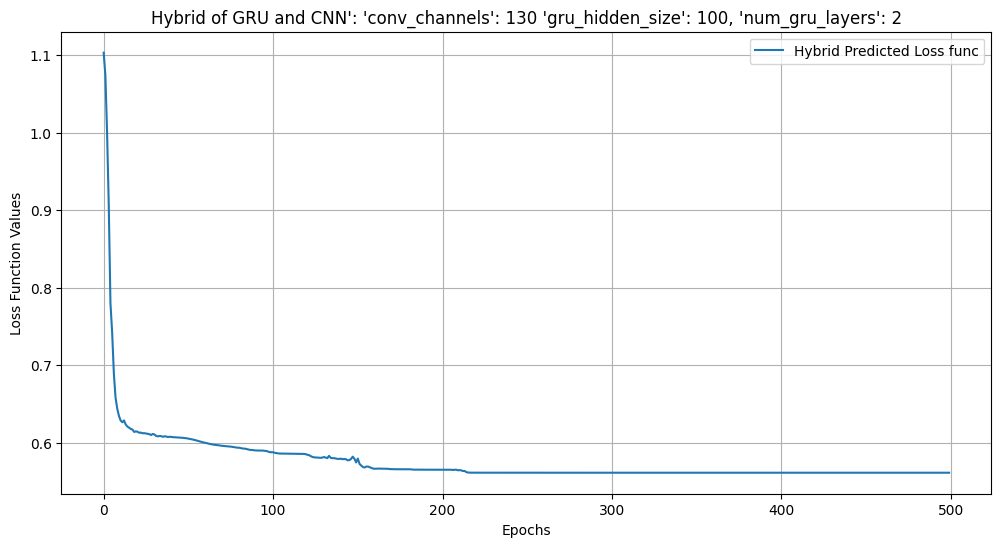

------------------------- for conv_channels = 135-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.0941
Epoch [51/500], Loss: 0.6023
Epoch [101/500], Loss: 0.5957
Epoch [151/500], Loss: 0.5955
Epoch [201/500], Loss: 0.5923
Epoch [251/500], Loss: 0.5687
Epoch [301/500], Loss: 0.5609
Epoch [351/500], Loss: 0.5609
Epoch [401/500], Loss: 0.5609
Epoch [451/500], Loss: 0.5609


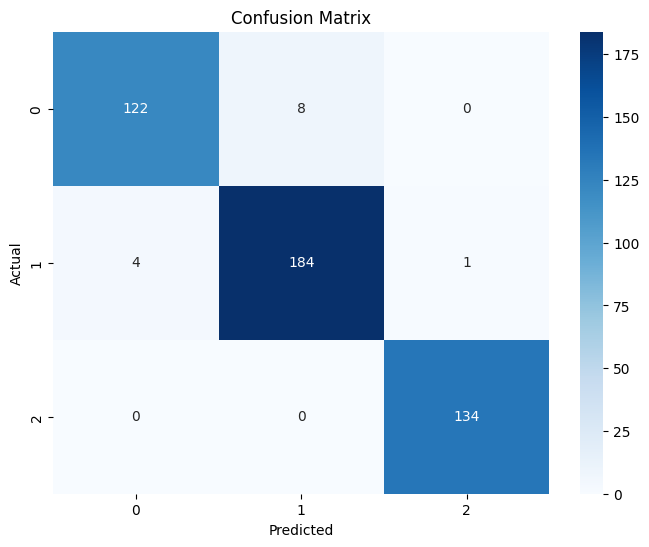

Hybrid of GRU and CNN Accuracy: 0.9713024282560706
Hybrid of GRU and CNN Confusion Matrix:
[[122   8   0]
 [  4 184   1]
 [  0   0 134]]
Hybrid of GRU and CNN Precision: 0.9713144001775349
Hybrid of GRU and CNN Recall: 0.9713024282560706
Hybrid of GRU and CNN F1 Score: 0.9712125603497167
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       130
           1       0.96      0.97      0.97       189
           2       0.99      1.00      1.00       134

    accuracy                           0.97       453
   macro avg       0.97      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453



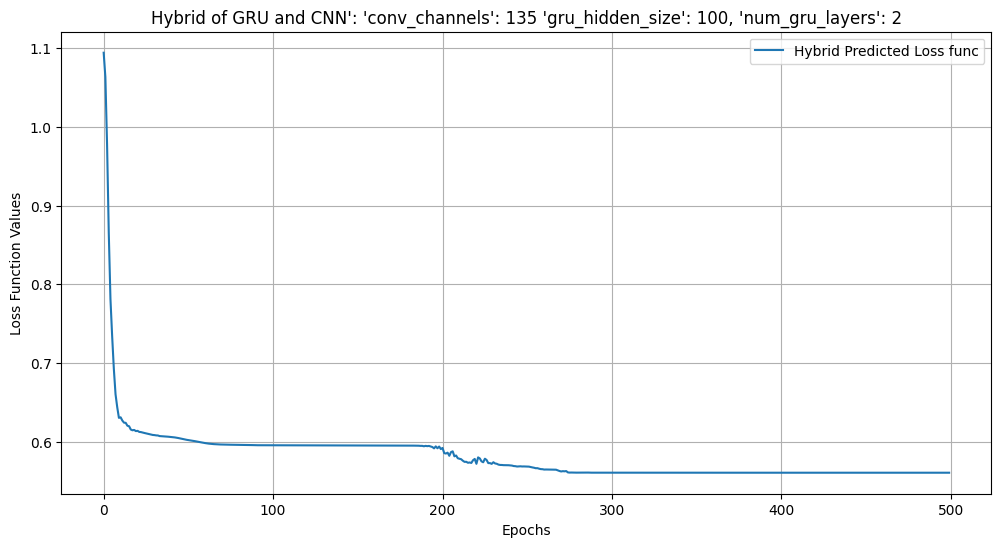

------------------------- for conv_channels = 140-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.0957
Epoch [51/500], Loss: 0.6072
Epoch [101/500], Loss: 0.5946
Epoch [151/500], Loss: 0.5946
Epoch [201/500], Loss: 0.5946
Epoch [251/500], Loss: 0.5946
Epoch [301/500], Loss: 0.5946
Epoch [351/500], Loss: 0.5946
Epoch [401/500], Loss: 0.5946
Epoch [451/500], Loss: 0.5946


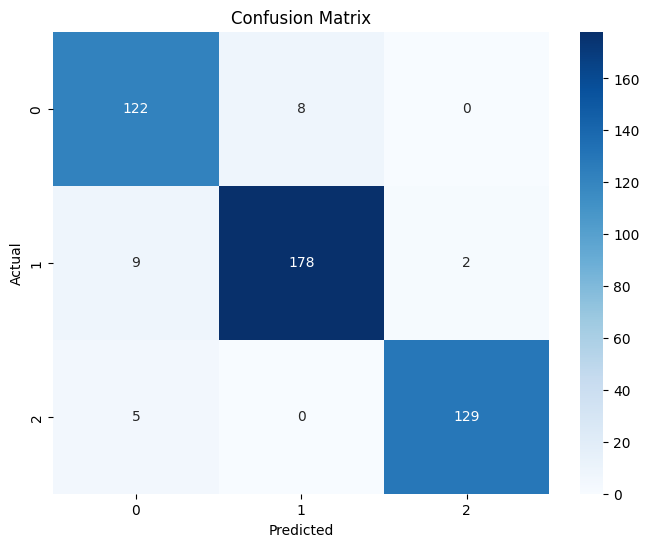

Hybrid of GRU and CNN Accuracy: 0.9470198675496688
Hybrid of GRU and CNN Confusion Matrix:
[[122   8   0]
 [  9 178   2]
 [  5   0 129]]
Hybrid of GRU and CNN Precision: 0.9479973802958972
Hybrid of GRU and CNN Recall: 0.9470198675496688
Hybrid of GRU and CNN F1 Score: 0.9473123568636699
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       130
           1       0.96      0.94      0.95       189
           2       0.98      0.96      0.97       134

    accuracy                           0.95       453
   macro avg       0.95      0.95      0.95       453
weighted avg       0.95      0.95      0.95       453



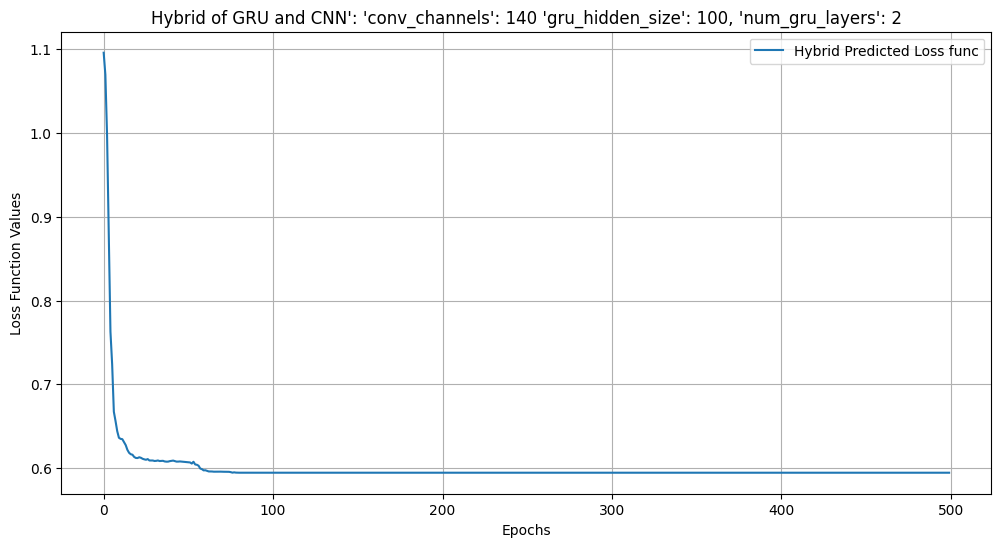

------------------------- for conv_channels = 145-------------------------------
input_seq shape = torch.Size([1808, 54, 1])
Epoch [1/500], Loss: 1.0987
Epoch [51/500], Loss: 0.5919
Epoch [101/500], Loss: 0.5826
Epoch [151/500], Loss: 0.5824
Epoch [201/500], Loss: 0.5662
Epoch [251/500], Loss: 0.5653
Epoch [301/500], Loss: 0.5653
Epoch [351/500], Loss: 0.5653
Epoch [401/500], Loss: 0.5653
Epoch [451/500], Loss: 0.5653


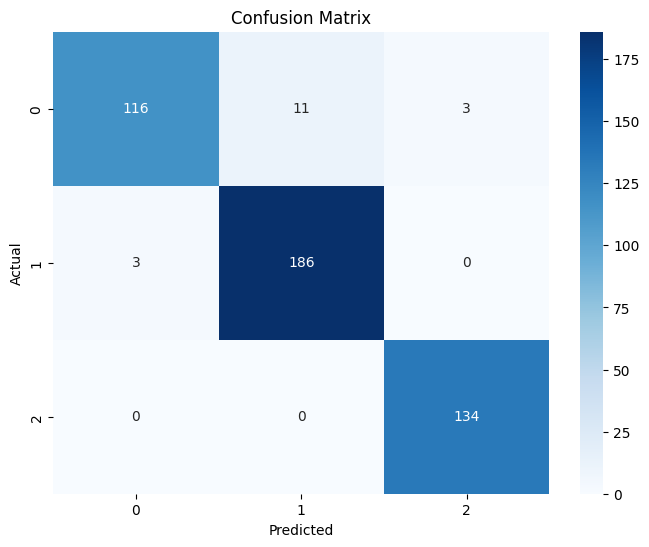

Hybrid of GRU and CNN Accuracy: 0.9624724061810155
Hybrid of GRU and CNN Confusion Matrix:
[[116  11   3]
 [  3 186   0]
 [  0   0 134]]
Hybrid of GRU and CNN Precision: 0.9629913532315705
Hybrid of GRU and CNN Recall: 0.9624724061810155
Hybrid of GRU and CNN F1 Score: 0.9620003992896838
Hybrid of GRU and CNN Classifier Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       130
           1       0.94      0.98      0.96       189
           2       0.98      1.00      0.99       134

    accuracy                           0.96       453
   macro avg       0.97      0.96      0.96       453
weighted avg       0.96      0.96      0.96       453



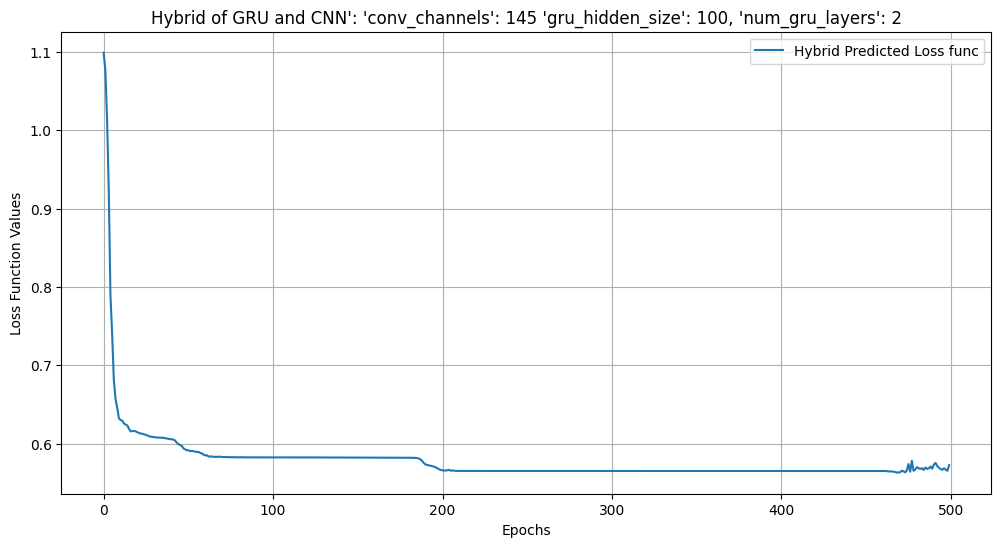

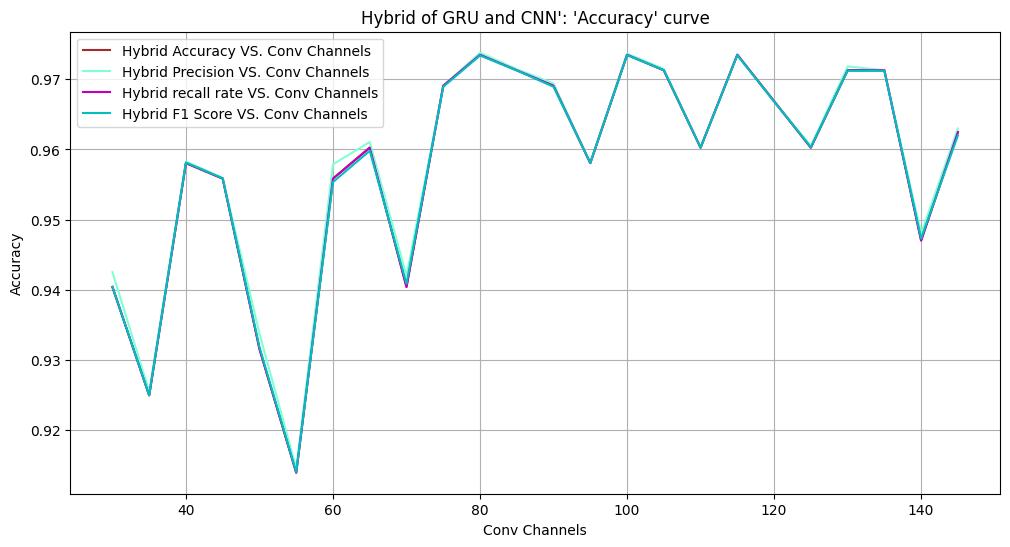

In [28]:
  # Assuming you have defined your HybridModel and DataLoader parameters
  conv_channels = 50
  gru_hidden_size = 100
  num_gru_layers = 2
  learning_rate = 0.01

  criterion = nn.CrossEntropyLoss()
  epochs=500
  accuracy_list = []
  f1_score_list = []
  recall_rate_list = []
  precision_list = []
  for conv_channels in range(30, 150, 5):
    print(f"------------------------- for conv_channels = {conv_channels}-------------------------------")
    hybrid_model = HybridModel(input_size, output_size, conv_channels, gru_hidden_size, num_gru_layers)
    optimizer = optim.Adam(hybrid_model.parameters(), lr=learning_rate)
    loss_list = train_model(hybrid_model, X_train.unsqueeze(2), y_train, criterion, optimizer, epochs)
    # Model Evaluation on the test set
    hybrid_model.eval()
    hybrid_test_outputs = predict(hybrid_model,X_test.unsqueeze(2))
    accuracy, precision, recall_rate, f1_score_value = evaluate_classifer(y_test, hybrid_test_outputs, "Hybrid of GRU and CNN", True)
    accuracy_list.append(accuracy)
    recall_rate_list.append(recall_rate)
    precision_list.append(precision)
    f1_score_list.append(f1_score_value)

    plt.figure(figsize=(12, 6))
    plt.plot(range(0, epochs, 1), loss_list, label="Hybrid Predicted Loss func")  # Add this line for GRU
    plt.legend()
    plt.title(f"Hybrid of GRU and CNN': 'conv_channels': {conv_channels} 'gru_hidden_size': {gru_hidden_size}, 'num_gru_layers': {num_gru_layers}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Function Values")
    plt.grid(True)
    plt.show()

  plt.figure(figsize=(12, 6))
  plt.plot(range(30, 150, 5), accuracy_list, color="brown", label="Hybrid Accuracy VS. Conv Channels")  # Add this line for GRU
  plt.plot(range(30, 150, 5), precision_list, color="aquamarine", label="Hybrid Precision VS. Conv Channels")  # Add this line for GRU
  plt.plot(range(30, 150, 5), recall_rate_list, color="m", label="Hybrid recall rate VS. Conv Channels")  # Add this line for GRU
  plt.plot(range(30, 150, 5), f1_score_list, color="c", label="Hybrid F1 Score VS. Conv Channels")  # Add this line for GRU

  plt.legend()
  plt.title(f"Hybrid of GRU and CNN': 'Accuracy' curve")
  plt.xlabel("Conv Channels")
  plt.ylabel("Accuracy")
  plt.grid(True)
  plt.show()